In [17]:
from pathlib import Path
import re
import numpy as np
import pandas as pd

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
)
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize

from text_clustering import (
    load_and_clean, embed_texts,
    reduce_dimensionality, cluster_points,
    inspect_clusters,compute_centroids,
    compute_distances
)
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

RANDOM_STATE   = 42
N_SPLITS       = 10
DATA_PATH      = Path(
    r"C:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\data\processed\dataset_clean.csv"
)
CV = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
def load_dataset(path: Path) -> pd.DataFrame:
    """Load CSV and create the lowercase, cleaned ‘req’ field + binary target."""
    df = pd.read_csv(path, parse_dates=["request_time_utc"])

    # combine title + edited text, lowercase, keep only letters & spaces
    df["req"] = (
        df.request_title.fillna("") + " " + df.request_text_edit_aware.fillna("")
    ).str.lower() \
     .str.replace(r"[^a-z]", " ", regex=True) \
     .str.replace(r"\s+", " ", regex=True) \
     .str.strip()

    df["target"] = df.requester_received_pizza.astype(int)
    return df


df = load_dataset(DATA_PATH)
print(f"Loaded {len(df):,} rows; sample req:\n{df.req.iloc[0][:100]}…")


Loaded 4,040 rows; sample req:
request colorado springs help us please hi i am in need of food for my children we are a military fa…


In [ ]:
#  Baseline feature generators

BUCKET_PATTERNS_old = {
    "d_money":   r" money| broke| pay| rent| bill| bank| loan| cash| financial| poor| budget",
    "d_job":     r" work| job| interview| employ| fire| hire",
    "d_student": r" college| student| school| university| semester| tuition",
    "d_family":  r" family| mom| dad| wife| husband| son| daughter| parent",
    "d_craving": r" friend| crave| craving| party| movie| game| beer| date",
}
BUCKET_PATTERNS = {
    # ─── Life situations or identities ────────────────────────────────────────
    "b_family":         r"\b(kid(?:s)?|child(?:ren)?|family|mom|dad|wife|husband|fianc[eé]e?|pregnant|son|daughter|girlfriend|boyfriend|partner|spouse)\b",
    "b_student":        r"\b(college|university|student|school|class|exam|finals?|semester|degree|textbook|tuition|professor|studying)\b",
    "b_disabled":       r"\b(disabled|disability|injur(?:y|ed)|wheelchair|chronic|herniated|stenosis|degenerative|surgery|doctor|physio|hospital|mri|neurologist)\b",

    # ─── Hardship / emergency ────────────────────────────────────────────────
    "b_eviction":       r"\b(evicted|eviction|homeless|shelter|nowhere\s+to\s+live|rent|landlord|foreclosure|sleep\s+outside)\b",
    "b_job_loss":       r"\b(lay[\s-]?off|unemployed|lost\s+my\s+job|jobless|looking\s+for\s+work|got\s+fired)\b",
    "b_new_job":        r"\b(start(?:ed|ing)?\s+a\s+job|new\s+job|first\s+day\s+of\s+work|hired|interview|training|orientation)\b",
    "b_broke":          r"\b(broke|no\s+money|low\s+on\s+cash|can't\s+afford|dead\s+broke|flat\s+broke)\b",
    "b_payday_gap":     r"\b(payday|pay\s?day|check\s+comes|next\s+pay|waiting\s+for\s+paycheck|friday\s+pay|until\s+next\s+check)\b",
    "b_urgent_hunger":  r"\b(hungry|starving|no\s+food|nothing\s+to\s+eat|empty\s+fridge|last\s+meal|need\s+food|can't\s+eat)\b",
    "b_medical_cost":   r"\b(er|emergency\s+room|hospital|doctor|prescription|crutches|meds?|x[-\s]?rays?|clinic|surgery|physio)\b",

    # ─── Emotional tone ──────────────────────────────────────────────────────
    "b_emotional":      r"\b(rock\s+bottom|desperate|freaking\s+out|panic|stressed|crisis|bad\s+day|overwhelmed|depressed|mental\s+health)\b",

    # ─── Reciprocity or trade ────────────────────────────────────────────────
    "b_artist_trade":   r"\b(draw|drawing|sketch|illustration|art(?:ist)?|design|graphic|crochet|knit|scarf|handmade|craft|gift|penguin|narwhal|abrictosaurus)\b",
    "b_pay_it_forward": r"\b(pay\s+it\s+forward|return\s+the\s+favor|repay|promise\s+to\s+help|give\s+back|one\s+day\s+repay)\b",

    # ─── Logistics / meta ────────────────────────────────────────────────────
    "b_logistics":      r"\b(domino(?:'s)?|papa\s+john(?:'s)?|pizza\s+place|order\s+online|delivery|address|coupon|gift\s?card|tracking\s+code)\b",

    # ─── Food staple requests ───────────────────────────────────────────────
    "b_ramen":          r"\b(ramen|noodles|peanut\s+butter|beans|rice|easy\s+mac|mac\s*and\s*cheese|canned\s+food|food\s+staples|groceries|pantry)\b",

    # ─── Other specific life contexts ───────────────────────────────────────
    "b_holiday":        r"\b(christmas|thanksgiving|holiday|new\s+year|easter|vacation|holiday\s+break)\b",
    "b_pet_emergency":  r"\b(dog|cat|pet|puppy|kitten|veterinarian|vet|animal\s+hospital)\b",
}


def add_narrative_buckets(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    for name, pat in BUCKET_PATTERNS.items():
        freq = df2.req.str.count(pat) / df2.req.str.split().str.len()
        nonzero = freq[freq > 0]
        edges = np.quantile(nonzero, np.linspace(0, 0.9, 10))
        df2[name] = np.where(freq == 0, 0, np.digitize(freq, edges, right=True) + 1)
    return df2


def add_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    req_times = df2.request_time_utc.dt.tz_convert(None)
    start = req_times.min().normalize()

    # community age deciles
    age_days = (req_times - start).dt.days.values.reshape(-1, 1)
    df2["d_comm_age"] = KBinsDiscretizer(
        n_bins=10, encode="ordinal", strategy="quantile"
    ).fit_transform(age_days).astype(int).flatten()

    # first half of month flag
    df2["month_h1"] = (req_times.dt.day <= 15).astype(int)
    return df2


def add_flag_features(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    df2["gratitude"]   = df2.req.str.contains(r"thank|appreciate|advance").astype(int)
    df2["hyperlink"]   = df2.req.str.contains(r"http").astype(int)
    df2["reciprocity"] = df2.req.str.contains(r"pay.+forward|repay|return.+favor").astype(int)
    return df2


def add_sentiment_buckets(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    df2["sentiment_score"] = df2.req.map(lambda t: TextBlob(t).sentiment.polarity)
    pos_med = df2.loc[df2.sentiment_score > 0, "sentiment_score"].median()
    neg_med = df2.loc[df2.sentiment_score < 0, "sentiment_score"].median()
    df2["sent_pos"] = (df2.sentiment_score > pos_med).astype(int)
    df2["sent_neg"] = (df2.sentiment_score < neg_med).astype(int)
    return df2


def add_length_and_karma(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    df2["req_len"] = df2.req.str.split().str.len()

    karma = df2.requester_upvotes_minus_downvotes_at_request.fillna(0).values.reshape(-1, 1)
    df2["d_karma"] = KBinsDiscretizer(
        n_bins=10, encode="ordinal", strategy="quantile"
    ).fit_transform(karma).astype(int).flatten()

    df2["posted_before"] = (
        df2.requester_number_of_posts_on_raop_at_request.fillna(0) > 0
    ).astype(int)
    return df2


def add_baseline_features(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.pipe(add_narrative_buckets)
          .pipe(add_temporal_features)
          .pipe(add_flag_features)
          .pipe(add_sentiment_buckets)
          .pipe(add_length_and_karma)
    )


In [ ]:

# Baseline Logistic Regression (10-fold CV)
BASELINE_FEATURES_new = [
    "d_money","d_job","d_student","d_family","d_craving",
    "d_comm_age","month_h1",
    "gratitude","hyperlink","reciprocity",
    "sent_pos","sent_neg",
    "req_len","d_karma","posted_before",
]

BASELINE_FEATURES = [
    # baseline
    "d_comm_age", "month_h1",
    "gratitude", "hyperlink", "reciprocity",
    "sent_pos", "sent_neg",
    "req_len", "d_karma", "posted_before",
    
    # New narrative buckets 
    "b_family", "b_student",
    
    # Hardship/emergency buckets
    "b_job_loss", "b_new_job", "b_broke",
    "b_payday_gap", "b_medical_cost",
    
    # Emotional tone
    "b_emotional",
    
    # Reciprocity or trade
    "b_pay_it_forward",
    
    "b_holiday"
]

def evaluate_model(model, X, y, cv=CV, scoring="roc_auc"):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return scores.mean(), scores.std()

df_baseline = add_baseline_features(df)
X_base = df_baseline[BASELINE_FEATURES]
y      = df_baseline["target"]

logreg_base = LogisticRegression(
    max_iter=1000, class_weight="balanced", solver="liblinear"
)

mean_auc, std_auc = evaluate_model(logreg_base, X_base, y)
print(f"Baseline 10-fold CV ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")


c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-

Baseline 10-fold CV ROC AUC: 0.653 ± 0.030


In [ ]:
# Scaled Logistic + Grid over C
pipe_scaled_lr = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="liblinear",
        class_weight=None,
        max_iter=1000
    ))
])

grid_scaled_lr = GridSearchCV(
    pipe_scaled_lr,
    param_grid={"clf__C": np.logspace(-4, 4, 9)},
    cv=CV, scoring="roc_auc", n_jobs=-1
)
grid_scaled_lr.fit(X_base, y)

print(f"Best C: {grid_scaled_lr.best_params_['clf__C']}")
print(f"Scaled + L2 CV ROC AUC: {grid_scaled_lr.best_score_:.3f}")


Best C: 0.01
Scaled + L2 CV ROC AUC: 0.653


In [ ]:
# Extended feature generators (time, activity, text, social…)
analyzer = SentimentIntensityAnalyzer()
TOP_SUBS = [
    "reddit.com","fffffffuuuuuuuuuuuu","Random_Acts_Of_Pizza",
    "pics","AskReddit","IAmA","funny","todayilearned","WTF","videos",
]

def add_time_features(df_in):
    df2 = df_in.copy()
    df2["request_time_utc"] = pd.to_datetime(df2["request_time_utc"], utc=True,
                                             errors="coerce")
    df2["hour"]     = df2.request_time_utc.dt.hour
    df2["hour_sin"] = np.sin(2*np.pi*df2.hour/24)
    df2["hour_cos"] = np.cos(2*np.pi*df2.hour/24)
    df2["dow"]      = df2.request_time_utc.dt.weekday
    df2["dow_sin"]  = np.sin(2*np.pi*df2.dow/7)
    df2["dow_cos"]  = np.cos(2*np.pi*df2.dow/7)
    df2["log_account_age"] = np.log1p(df2.requester_account_age_in_days_at_request)
    return df2


def add_activity_features(df_in):
    df2 = df_in.copy()
    age = df2.requester_account_age_in_days_at_request.replace(0, np.nan)
    df2["posts_per_day"]      = df2.requester_number_of_posts_at_request / age
    df2["comments_per_day"]   = df2.requester_number_of_comments_at_request / age
    df2["votes_per_day"]      = df2.requester_upvotes_plus_downvotes_at_request / age
    df2["subreddits_per_day"] = df2.requester_number_of_subreddits_at_request / age
    return df2


def add_text_features(df_in):
    df2 = df_in.copy()
    txt = df2.req.fillna("").astype(str)
    df2["n_chars"]   = txt.str.len()
    df2["n_words"]   = txt.str.split().str.len()
    df2["cnt_please"] = txt.str.lower().str.count(r"\bplease\b")
    df2["cnt_thank"]  = txt.str.lower().str.count(r"\bthank\b")
    df2["vader_sent"] = txt.map(lambda t: analyzer.polarity_scores(t)["compound"])
    return df2


def add_social_features(df_in):
    df2 = df_in.copy()
    df2["vote_sum"]   = df2.requester_upvotes_plus_downvotes_at_request
    df2["vote_diff"]  = df2.requester_upvotes_minus_downvotes_at_request
    df2["vote_ratio"] = df2.vote_diff / df2.vote_sum.replace(0, np.nan)
    return df2


def add_interaction_features(df_in):
    df2 = df_in.copy()
    df2["hour_sentiment"] = df2.hour_sin * df2.vader_sent
    df2["length_upvote"]  = df2.n_words * df2.vote_ratio
    return df2


def add_subreddit_features(df_in):
    df2 = df_in.copy()
    lists = df2["requester_subreddits_at_request"]
    for sub in TOP_SUBS:
        df2[f"sub_{sub}"] = lists.apply(lambda L: 1 if sub in L else 0)
    df2["num_top_subs"] = df2[[f"sub_{s}" for s in TOP_SUBS]].sum(axis=1)
    return df2


In [ ]:
# Noun-only DTM, LDA topics (k=10) & K-means distance features
def extract_nouns_tb(text: str) -> str:
    blob = TextBlob(text)
    return " ".join(w for w, pos in blob.tags if pos.startswith("NN"))


def build_topic_and_distance_features(df_in, k_topics=10, k_clusters=5):
    df2 = df_in.copy()
    df2["req_nouns"] = df2.req.map(extract_nouns_tb)

    # Build noun DTM
    extra_stop = {"pizza","request","food","help","raop","random","act","please","thanks"}
    cvect = CountVectorizer(
        stop_words=list(ENGLISH_STOP_WORDS.union(extra_stop)),
        min_df=20, max_df=0.50
    )
    dtm = cvect.fit_transform(df2["req_nouns"])
    terms = cvect.get_feature_names_out()

    # Trim with tf-idf bottom quartile
    tfidf_mat = TfidfTransformer(norm=None, use_idf=True).fit_transform(dtm)
    avg_tfidf = tfidf_mat.mean(axis=0).A1
    keep_idx  = np.where(avg_tfidf >= np.quantile(avg_tfidf, 0.25))[0]
    dtm_trim  = dtm[:, keep_idx]
    trim_terms = terms[keep_idx]

    # LDA
    lda = LatentDirichletAllocation(
        n_components=k_topics,
        random_state=RANDOM_STATE
    ).fit(dtm_trim)
    topic_dists = lda.transform(dtm_trim)
    for i in range(k_topics):
        df2[f"lda_topic_{i}"] = topic_dists[:, i]

    # K-means on normalised DTM
    dtm_norm = normalize(dtm_trim, axis=1)
    km = KMeans(n_clusters=k_clusters, random_state=RANDOM_STATE).fit(dtm_norm)
    dists = pairwise_distances(dtm_norm, km.cluster_centers_)
    for j in range(k_clusters):
        df2[f"km_dist_{j}"] = dists[:, j]

    return df2




In [ ]:
# Build the extended DataFrame
df_ext = (
    df
    .pipe(add_baseline_features)       
    .pipe(add_time_features)
    .pipe(add_activity_features)
    .pipe(add_text_features)
    .pipe(add_social_features)
    .pipe(add_interaction_features)
    .pipe(add_subreddit_features)
    .pipe(build_topic_and_distance_features) 
)

OLD_BUCKETS = {"d_money","d_job","d_student","d_family","d_craving"}

TEMPORAL_FEATURES = [
    "hour_sin", "hour_cos", "dow_sin", "dow_cos", "log_account_age"
]

ACTIVITY_FEATURES = [
    "posts_per_day", "comments_per_day", "votes_per_day", "subreddits_per_day"
]

# text features
TEXT_FEATURES = [
    "n_chars", "n_words", "cnt_please", "cnt_thank", "vader_sent"
]

# ocial features
SOCIAL_FEATURES = [
    "vote_sum", "vote_diff", "vote_ratio"
]

# interaction features
INTERACTION_FEATURES = [
    "hour_sentiment", "length_upvote"
]

# ubreddit features
SUBREDDIT_FEATURES = [f"sub_{sub}" for sub in TOP_SUBS] + ["num_top_subs"]

# topic modeling and clustering features
TOPIC_FEATURES = [f"lda_topic_{i}" for i in range(10)]
CLUSTER_FEATURES = [f"km_dist_{i}" for i in range(5)]

FEATURE_COLUMNS = (
    [c for c in BASELINE_FEATURES if c not in OLD_BUCKETS] +   # keep baseline minus old buckets
    TEMPORAL_FEATURES + 
    ACTIVITY_FEATURES + 
    TEXT_FEATURES + 
    SOCIAL_FEATURES + 
    INTERACTION_FEATURES + 
    SUBREDDIT_FEATURES +
    TOPIC_FEATURES + 
    CLUSTER_FEATURES
)

print(f"df_ext shape: {df_ext.shape}  |  using {len(FEATURE_COLUMNS)} features")

c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-

df_ext shape: (4040, 118)  |  using 65 features


In [ ]:
#Logistic on all features (impute → scale → grid over C)

X_ext = df_ext[FEATURE_COLUMNS]


pipe_ext_lr = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler()),
    ("clf",    LogisticRegression(
        penalty="l2",
        solver="liblinear",
        class_weight="balanced",
        max_iter=1000
    )),
])

grid_ext_lr = GridSearchCV(
    pipe_ext_lr,
    param_grid={"clf__C": np.logspace(-4, 4, 9)},
    cv=CV, scoring="roc_auc", n_jobs=-1
)
grid_ext_lr.fit(X_ext, y)

print(f"Best C (extended): {grid_ext_lr.best_params_['clf__C']}")
print(f"Extended scaled + L2 CV ROC AUC: {grid_ext_lr.best_score_:.3f}")


Best C (extended): 0.01
Extended scaled + L2 CV ROC AUC: 0.656


In [ ]:
EMB_CACHE = Path(r"C:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\embeddings_all-MiniLM-L6-v2.npy")
EMB_MODEL = Path(r"C:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\all-MiniLM-L6-v2")
if EMB_CACHE.exists():
    embs = np.load(EMB_CACHE)
    print("Loaded cached SBERT embeddings:", embs.shape)
else:
    embs = embed_texts(
        df["req"].tolist(),
        model_name=str(EMB_MODEL),
        batch_size=32
    )
    np.save(EMB_CACHE, embs)

df, texts = load_and_clean(
    str(DATA_PATH),
    text_column="request_text_edit_aware"
)

# SBERT embeddings
embs = embed_texts(
    texts,
    model_name=str(EMB_MODEL),
    batch_size=32
)

#UMAP projection
X_umap, _ = reduce_dimensionality(
    embs,
    n_components=50,
    n_neighbors=15,
    min_dist=0.0,
    metric="cosine",
    seed=42
)

#  HDBSCAN clustering
labels, _ = cluster_points(
    X_umap,
    min_cluster_size=20,
    min_samples=15,
    metric="euclidean"
)

df["cluster_id"] = labels.astype(int)

import numpy as np
unique, counts = np.unique(labels, return_counts=True)
print("Cluster ID → count")
for cid, cnt in zip(unique.astype(int), counts):
    label = "noise" if cid < 0 else f"cluster {cid}"
    print(f"  {label:>8}: {cnt}")

inspect_clusters(texts, labels, examples=3, width=80)

df.head()


Loaded cached SBERT embeddings: (3932, 384)


c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster ID → count
     noise: 2452
  cluster 0: 35
  cluster 1: 31
  cluster 2: 52
  cluster 3: 42
  cluster 4: 29
  cluster 5: 47
  cluster 6: 25
  cluster 7: 26
  cluster 8: 127
  cluster 9: 34
  cluster 10: 56
  cluster 11: 25
  cluster 12: 36
  cluster 13: 20
  cluster 14: 32
  cluster 15: 35
  cluster 16: 131
  cluster 17: 169
  cluster 18: 68
  cluster 19: 40
  cluster 20: 87
  cluster 21: 288
  cluster 22: 45

=== Cluster 0 (size=35) ===
 • the title says it all i am about to turn 18. when i do that means cutting a lot…
 • so on the 6th it is my birthday. i am posting this now so that more people get…
 • my birthday is in two days and i don't usually celebrate it. but, i would enjoy…

=== Cluster 1 (size=31) ===
 • i live on maui and pizza is my favorite food. can play some acoustic guitar…
 • and i'd really like a pizza -- something of real sustenance to put into my…
 • ive been eating nothing but rice and when im lucky ramen for almost 4 months…

=== Cluster 2 (size=52) ===
 

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,request_text_original,request_text_edit_aware_original,request_title_original,request_text_length,request_text_word_count,request_text_edit_aware_length,request_text_edit_aware_word_count,request_title_length,request_title_word_count,cluster_id
0,NaN,0,1,False,t3_l25d7,0,hi i am in need of food for my 4 children we a...,hi i am in need of food for my 4 children we a...,request colorado springs help us please,0.000000,...,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,316,67,316,67,39,6,-1
1,NaN,2,5,False,t3_rcb83,0,i spent the last money i had on gas today. im ...,i spent the last money i had on gas today. im ...,"[request] california, no cash and i could use ...",501.111100,...,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",74,16,74,16,57,10,-1
2,NaN,0,3,False,t3_lpu5j,0,my girlfriend decided it would be a good idea ...,my girlfriend decided it would be a good idea ...,"[request] hungry couple in dundee, scotland wo...",0.000000,...,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",277,59,277,59,66,10,-1
3,NaN,0,1,True,t3_mxvj3,4,"it's cold, i'n hungry, and to be completely ho...","it's cold, i'n hungry, and to be completely ho...","[request] in canada (ontario), just got home f...",6.518438,...,"It's cold, I'n hungry, and to be completely ho...","It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",171,30,171,30,69,11,-1
4,NaN,6,6,False,t3_1i6486,5,hey guys: i love this sub. i think it's great....,hey guys: . i think it's great. (except the so...,[request] old friend coming to visit. would lo...,162.063252,...,hey guys:\n I love this sub. I think it's grea...,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,488,103,488,103,81,14,21


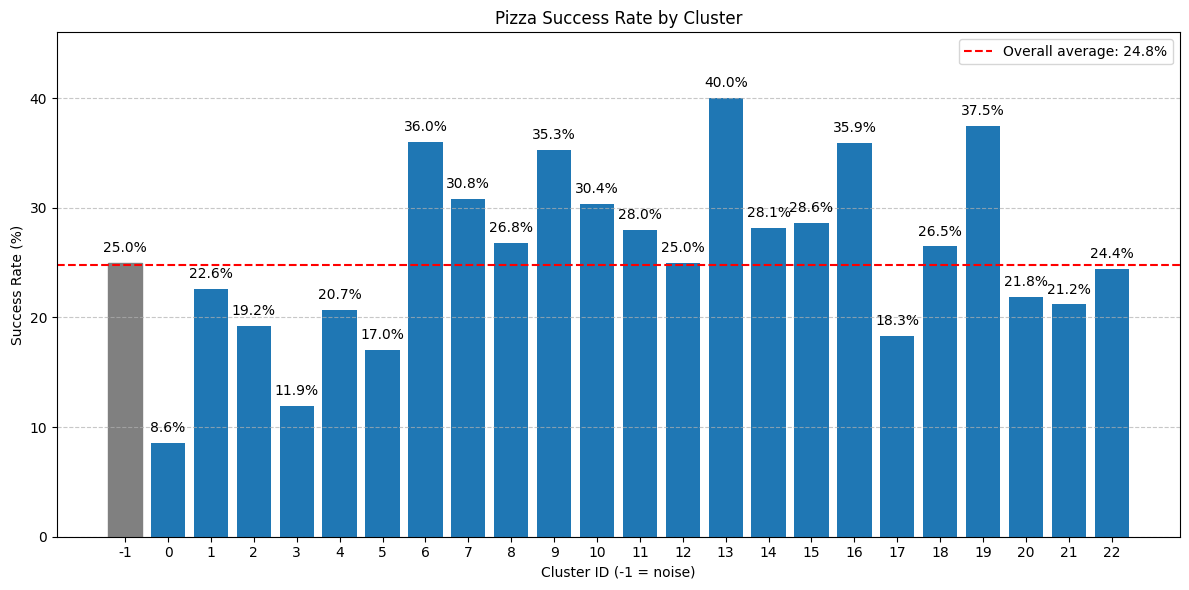

Cluster success rates:
            success_rate  cluster_size
cluster_id                            
-1             24.959217          2452
 0              8.571429            35
 1             22.580645            31
 2             19.230769            52
 3             11.904762            42
 4             20.689655            29
 5             17.021277            47
 6             36.000000            25
 7             30.769231            26
 8             26.771654           127
 9             35.294118            34
 10            30.357143            56
 11            28.000000            25
 12            25.000000            36
 13            40.000000            20
 14            28.125000            32
 15            28.571429            35
 16            35.877863           131
 17            18.343195           169
 18            26.470588            68
 19            37.500000            40
 20            21.839080            87
 21            21.180556           288
 2

In [ ]:
# success rate per cluster
success_rates = df.groupby('cluster_id')['requester_received_pizza'].mean().sort_index() * 100


plt.figure(figsize=(12, 6))
bars = plt.bar(success_rates.index.astype(str), success_rates.values)

for i, bar in enumerate(bars):
    if success_rates.index[i] == -1:
        bar.set_color('gray')

for i, v in enumerate(success_rates):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.axhline(df['requester_received_pizza'].mean() * 100, color='red', linestyle='--', 
            label=f'Overall average: {df["requester_received_pizza"].mean()*100:.1f}%')
plt.xlabel('Cluster ID (-1 = noise)')
plt.ylabel('Success Rate (%)')
plt.title('Pizza Success Rate by Cluster')
plt.xticks(rotation=0)
plt.ylim(0, max(success_rates) * 1.15)  
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Cluster success rates:")
cluster_stats = df.groupby('cluster_id').agg(
    success_rate=('requester_received_pizza', 'mean'),
    cluster_size=('requester_received_pizza', 'size')
).sort_index()
cluster_stats['success_rate'] *= 100
print(cluster_stats)

In [ ]:
#blob similarity & keyword deciles
import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util

def add_blob_similarity(df_in: pd.DataFrame,
                        embs: np.ndarray | torch.Tensor,
                        reference_blobs: dict,
                        model_path,
                        top_k: int = 3):

    if not isinstance(embs, torch.Tensor):
        embs = torch.tensor(embs)

    # Encode only the reference blobs
    model     = SentenceTransformer(str(model_path))
    blob_ids  = list(reference_blobs)
    blob_vecs = model.encode(list(reference_blobs.values()),
                             convert_to_tensor=True)

    sims = util.cos_sim(embs, blob_vecs).cpu().numpy() 

    df2      = df_in.copy()
    sim_cols = [f"sim_blob_{bid}" for bid in blob_ids]
    df2[sim_cols]                 = sims
    df2["blob_sim_max"]           = sims.max(axis=1)
    df2[f"blob_sim_top{top_k}_avg"] = np.sort(sims, axis=1)[:, -top_k:].mean(axis=1)
    df2["blob_best_id"]           = sims.argmax(axis=1).astype(int)
    return df2


def add_bucket_deciles(df_in: pd.DataFrame, pattern_dict: dict):
    df2 = df_in.copy()
    if "req_len" not in df2:
        df2["req_len"] = df2["req"].str.split().str.len()

    for name, pat in pattern_dict.items():
        freq   = df2["req"].str.count(pat) / df2["req_len"].replace(0, np.nan)
        nz     = freq[freq > 0]
        edges  = np.quantile(nz, np.linspace(0, .9, 10)) if nz.any() else []
        df2[name] = np.where(freq == 0, 0,
                             np.digitize(freq, edges, right=True) + 1)
    return df2


def ensure_core_columns(df_in: pd.DataFrame,
                        text_col: str = "request_text_edit_aware",
                        time_col: str = "request_time_utc") -> pd.DataFrame:

    df2 = df_in.copy()

    if "req" not in df2.columns:
        df2["req"] = (
            df2.request_title.fillna("") + " " + df2[text_col].fillna("")
        ).str.lower()                       \
         .str.replace(r"[^a-z]", " ", regex=True) \
         .str.replace(r"\s+", " ", regex=True)    \
         .str.strip()

    if "target" not in df2.columns and "requester_received_pizza" in df2.columns:
        df2["target"] = df2.requester_received_pizza.astype(int)

    if time_col in df2.columns and not np.issubdtype(df2[time_col].dtype, np.datetime64):
        df2[time_col] = pd.to_datetime(df2[time_col], errors="coerce", utc=True)

    return df2



In [30]:
reference_blob_todelete = """
Hello RAOP—today is my birthday, and after covering some unexpected bills I’m left with almost no cash. My family even forgot to celebrate, and this is my first time asking here. A pizza right now would truly lift my spirits and turn this disappointing day around. I’d be so grateful for your kindness and promise to pay it forward once I’m back on my feet. Thank you!


"""

reference_blob_0 = """
Hello everyone—today is my birthday, and I’ve never felt more at a loss. I’m a college student who just paid tuition and rent, currently unemployed, with only a few dollars left in my bank account. Normally I’d treat myself to a slice or two to celebrate, but this year I simply can’t afford even that small comfort. My birthday has always been a reminder to be grateful, but right now it feels like just another tough day. If anyone could help me out with a pizza, it would lift my spirits in a way I truly need—and I promise to pay your kindness forward when I’m back on solid ground. Thank you from the bottom of my heart for any help you can offer
"""

reference_blob_1 = """

Cluster theme: college musicians who’ve literally run out of food and money, offering to write and record songs in exchange for pizza.

I’m a full-time university student and musician who has just hit $0.00 on my meal card and finished the last of my Easy Mac and sandwiches. With finals next week and no groceries left, I need to survive until payday in seven days.

If you send me a pizza today, I will:
  1. Send you a *demo MP3 link* of a fully-produced song or jingle—in any genre (folk, orchestral, jazz, electronic, rock).
  2. Share my SoundCloud/YouTube samples (3,000+ subscribers) so you know exactly what you’ll get—before you order.
  3. Publicly credit you with a shout-out in my next video or Kickstarter update.
  4. Pay it forward by composing another custom track for someone else as soon as I get paid.

Thank you so much for considering this—I truly appreciate any help right now. Your kindness will keep me fed and inspired through finals week.
"""

reference_blob_2 = """
Cluster theme: genuine pay-it-forward pizza asks from people truly in need.

I’m completely out of funds and struggling today—this is my very first request and I’ve hit $0.00 in my account.  
If you can help me with a pizza right now, I would appreciate it more than you can imagine.  
I promise to pay your kindness forward as soon as I’m back on my feet:  
  • I will send you a pizza offer or return the favor on Friday when I have money again.  
  • I’ll provide any proof or verification you need to confirm delivery.  
Thank you so much for considering this—your help means everything, and I will pay it forward the moment I’m able.
"""

reference_blob_3 = """
Cluster theme: “No sob story” pizza requests—short, direct, self-aware pleas from people who’ve just paid bills and have zero funds left.

No sob story—just paid rent and utilities, and my bank balance is $0.00. I’ve been living on ramen and would really love a pizza slice tonight to break the routine. If you send a pie, I will:
  • Stretch it across a couple of meals and share with my little brother/roommate.  
  • Send you a quick, genuine thank-you note with a smiley :-)  
  • Pay it forward next week when I’m back on my feet.

No dramatics—only heartfelt gratitude for any slice you can spare. Thanks so much!
"""

reference_blob_4 = """
Cluster theme: urgent pizza (“pie”) requests from people who are truly out of food and money.

I’m completely out of groceries and cash—my pantry is empty and I’ve eaten my last meal. I’m starving right now and need to hold on until payday in two–three days. If you can spare me a pizza today, I will:
  1. Truly appreciate it and send heartfelt thanks immediately.
  2. Pay your kindness forward with a pizza gift to another Redditor on payday.
  3. Share a photo or confirmation code on request so you know it arrived.

Thank you so much for helping me and keeping me fed when I’m at my lowest. Your generosity means the world.
"""

reference_blob_5 = """
Cluster theme: artists and crafters offering specific creative trades (drawing, Photoshop, crocheting, graphic design) in exchange for pizza.

I’m a broke art student/designer with $0.00 in my bank account and no food in the fridge—just finished my last sandwich. If you send me a pizza today, I will:
  1. Deliver a **high-quality**, **bounded‐scope** piece:  
     – A custom sketch or digital illustration within 24–48 hours  
     – A half-finished scarf completed and shipped in 3–4 days (your choice of colors)  
     – Up to 5 photo retouches or a simple logo/graphic in PSD/AI format  
  2. Provide **samples or links** up front (Imgur/DeviantArt/Behance) so you know my style.  
  3. Share an “edit—fulfilled!” update with proof once your pizza arrives.  
  4. Pay it forward by creating another small piece for someone else when I get paid.

Thank you so much—I truly appreciate any help and will make good on every promise.
"""

reference_blob_6 = """
Cluster theme: creative‐service‐for‐pizza requests—offering custom drawings, apps, songs, or other creations in exchange for a pie.

I’ve run completely out of food and money—my meal card is empty, my food stamps broke, and I’m literally going hungry until my next paycheck. 
If you can spare me a pizza today, I will:
  1. Create and deliver a high-quality custom [drawing/app/song/paragraph] in whatever style or topic you choose.
  2. Send you a verification link or screenshot (demo image, code snippet, MP3 link) before you order, so you know I’ll follow through.
  3. Publicly thank you with a shout-out on my channel or in an “edit:” update once I’ve received it.
I truly appreciate any help right now—your kindness will keep me fed and inspired. Thank you so much!
"""

reference_blob_7 = """
Cluster theme: urgent pet‐related hardship—owners who’ve spent their last dollars on vet bills or pet food, now out of money and food themselves.

I’ve just hit $0.00 after paying emergency vet bills and my pantry is completely bare—no ramen, no bread, nothing until payday. My beloved pet (kitten with a broken paw / rescued stray / long‐time companion) needs me, and I’m desperate for a pizza tonight so we both don’t go hungry.

If you send a pizza now, I will:
  1. Share a photo proof of me and my pet (or vet receipt) immediately upon delivery.  
  2. Publicly thank you in a thank‐you thread with pet pictures.  
  3. Pay it forward by covering another RAOP request once I’m back on my feet.

Thank you from me and my [cat/kitten/dog]—your kindness literally keeps us alive tonight.
"""

reference_blob_8 = """
Cluster theme: Pizza appeals from people surviving on ramen and minimal staples under urgent financial strain.

I’m completely out of money and surviving on nothing but instant ramen, rice, and frozen veggies until my next paycheck.  
Our cupboards are bare, rent is due soon, and I need to feed myself (and sometimes my kids) tonight.  
If you send me a pizza, I will:
  1. Send a photo or verification code on delivery to prove it arrived.  
  2. Pay your kindness forward or reimburse you on payday.  
  3. Publicly thank you in an edit or comment once I’ve received it.

Thank you so much—your help would mean a real, immediate relief from another bowl of noodles.
"""

reference_blob_9 = """
Cluster theme: surprising or supporting a partner/family member with pizza when finances or circumstances are tight.

I’m completely out of extra money and need to brighten my fiancée/wife/girlfriend’s day—she’s seven months pregnant, pulling double shifts, or I’ve been laid up with an injury.  
If you send us a pizza tonight, I will:
  1. Order exactly to our location (Domino’s/Papa John’s e-card to [address] with no olives or peppers).  
  2. Provide any verification code or proof of delivery.  
  3. Publicly thank you in an edit once delivered (“fulfilled by u/you, thank you so much!”).  
  4. Pay this kindness forward as soon as I’m back on my feet.

Thank you—your help means the world to us and will make her week.  
"""

reference_blob_10 = """
Cluster theme: highly detailed logistical pizza or e‐gift‐card requests specifying exact brand, price, payment method, and pickup/delivery instructions.

I’ve literally run out of food and money until payday—£0.00 in my account and no groceries—and desperately need a pizza today.  
If you can help, please note:
  • Order from Domino’s (personal pizza £5.99) or Papa John’s (one‐topping large £5.99) via dominos.co.uk or the Papa Johns coupon code.  
  • I can walk 30 min to pick up if paid by card, or provide my PayPal (£3.20 balance) to swap gift-cards at exact value.  
  • Send me a verification code or PM me for email details to confirm delivery.  
  • I will absolutely pay your kindness forward the moment I’m back on my feet (gift-card swap, photoshop work, or another pizza).

Thank you so much—this precise help will keep me fed until payday and I truly appreciate it.
"""

reference_blob_11 = """
Cluster theme: parents (often single or stay-at-home) facing acute financial hardship who just want to share a pizza night with their young children.

I’m completely out of food and money—my last groceries ran out days ago, and with rent, bills, and daycare costs I have nothing left to feed my kids tonight.  
If you send us a pizza now, I will:
  1. Provide a verification code or pickup details so you know it was used.
  2. Share the exact ages and names of my children (e.g., Jason, 6; Michelle & Christina, 3½) to personalize my gratitude.
  3. Promise to pay it forward or repay next payday—your kindness will become someone else’s pizza.
  4. Publicly thank you by name in an edit when the request is fulfilled.

Thank you from the bottom of my heart; helping my family tonight means everything to us.
"""

reference_blob_12 = """
Cluster theme: people having an emotionally awful “bad day/week” and hungry, asking for pizza as a pick-me-up.

Today has been the worst: my work was canceled at the last minute for the second time this month, I'm completely broke and have no food left (just finished my last slice of bread), and I need to survive until payday. Pizza would not only fill my stomach but lift me out of despair.

If you send me a pizza now, I will:
  1. Publicly thank you in an edit with delivery proof.
  2. Pay it forward by treating someone else when I get paid next week.
  3. Share a short video or message showing my gratitude.

Thank you so much—it would literally turn my entire day around.
"""

reference_blob_13 = """
Cluster theme: deeply personal sob-stories of financial & emotional crisis, pleading for pizza as a vital boost.

I have literally $0.00 in my bank and haven’t eaten a real meal in days—I’m surviving on canned beans and rice only. I lost my job/car/home [brief crisis summary], and every bill is past due. Right now I’m at rock bottom and desperately need a pizza to keep me afloat.

If you can spare a pie today, I will:
  1. Send you a verification screenshot or “edit: received!” update immediately upon delivery.  
  2. Publicly thank you in my next post and commit to paying your kindness forward as soon as I’m back on my feet.  
  3. Offer a small service (advice, a shout-out, or anything modest) to show my gratitude.

Thank you so much—your help today literally means the difference between going hungry or not.  
"""

reference_blob_14 = """
Cluster theme: asking for pizza on behalf of a friend, family member, or partner in acute crisis.

I’m not asking for myself but for someone who’s facing a real emergency right now—my best friend had his phone stolen in a break-in and just lost his paycheck, my son landed in the ER with a busted lip and was so brave, my roommate’s car broke down 100 miles from home leaving him stranded and hungry, or a neighbor’s six-year-old broke his leg and is heartbroken.

If you can send a pizza tonight, you’ll:
  1. Put food in the hands of someone who genuinely needs a boost.
  2. Bring a moment of relief and joy during a stressful, time-sensitive situation.
  3. Hear my heartfelt thanks—and I’ll gladly verify delivery or pay it forward as soon as I’m able.

Your kindness will turn a tough night into hope for someone who’s been through enough already. Thank you so much for considering this.
"""

reference_blob_15 = """
Cluster theme: family-oriented pizza requests to feed children or dependents in genuine need.

I’m out of food and funds right now—our last groceries are gone and we’re waiting on benefits/payday in the next few days.  
If you can send us a pizza today to feed me and my kids (or my classroom of first-graders), I will:
  1. Provide a verification code or delivery confirmation immediately.
  2. Share exactly how much your kindness lifted us when our food stamps haven’t arrived.
  3. Pay this forward by covering another family’s meal as soon as I can.

Thank you so much for helping keep little ones fed and happy. Your generosity means the world to us.
"""

reference_blob_16 = """
Cluster theme: urgent, story-driven sob-story pizza requests from families or couples who’ve run out of food and money.

We have absolutely no groceries left—our fridge and pantry are empty, our bank account sits at $0.00, and bills (rent, utilities, medical) are overdue or shut off.  
If you can spare us a pizza right now, we will:
  1. Provide any verification you need (shut-off notice, negative balance screenshot, eviction notice).  
  2. Share an “edit: request fulfilled” update and thank you post with proof and photos.  
  3. Pay it forward or reimburse you on a specific date (e.g. “I’ll gift a pizza on the 28th when I get paid,” “after my first post-paycheck purchase in October”).  
Thank you from the bottom of our hearts—your kindness will feed our family today and inspire us to help someone else as soon as we’re back on our feet.
"""

reference_blob_17 = """
Cluster theme: broke college students begging for pizza as study fuel during finals/projects.

I have literally $0.00 in my account and have been surviving on peanut butter, rice & beans, or tapioca pudding while cramming for exams and finishing major projects. My campus dining plan ran out days ago and there’s nothing but empty cupboards.

If you send me (and my roommates/study group) a pizza tonight, I will:
  1. Share slices with everyone so we can power through our all-nighter together.
  2. Send you a quick photo or webcam proof of our pizza-fueled study session.
  3. Promise to pay this kindness forward (and buy another student a pizza) the moment I get paid or my next grant disbursement arrives.

Thank you so much for helping a starving student survive finals week—I genuinely appreciate it and will keep the generosity going.
"""

reference_blob_18 = """
Cluster theme: emergency banking failures—stolen, frozen, or declined cards—leaving people with zero access to funds and no food until their account is restored.

My debit card was frozen/stolen last weekend, and my bank won’t issue a new one until Monday (or next business day). I have $0.00 in my checking account, no cash on hand, and only a few eggs/ramen/bread left. Until I can walk into the branch and withdraw my own money, I literally have no way to buy food.

If you can spare me a pizza today, I will:
  1. Provide proof of my frozen/declined account (bank email screenshot or verification code).
  2. Promise I’ll pay it forward or repay you as soon as my new card arrives—tomorrow or on payday.
  3. Deeply thank you and commit to passing along this kindness to someone else in need.

Thank you so much for considering this urgent request—I truly appreciate any help right now.
"""

reference_blob_19 = """
Cluster theme: “payday gap” requests—new/shifted job pay schedule leaves you broke until your first or next paycheck.

I’ve just started a job (or had my pay delayed) and won’t see any money until [day of week or date]. Right now I’m down to $0–$12 in my bank account, no groceries left, and I need food to get to work/class tomorrow.

If you can send me a pizza today, I will:
  1. Provide proof on request—bank screenshot, emailed schedule, or verification code—before or after delivery.
  2. Clearly state exactly when I’ll pay it forward or repay you (e.g. “I get paid Friday the 16th and will send a gift/card that day”).
  3. Share a brief edit/update here (“request fulfilled—thank you!”) as social proof.
  4. Offer a small token of thanks in return (minor Photoshop work, answering questions, or simply a public shout-out).

Thank you so much—I truly appreciate any help and will make good on every promise as soon as my paycheck hits.
"""

reference_blob_20 = """
Cluster theme: urgent hunger and food scarcity pleas needing immediate pizza relief.

I have absolutely no food or funds right now—my bank balance is £0.07/$0.00 and I’ve eaten the last of my crackers and applesauce.  
I’m stuck until my next paycheck/benefit arrives (in 2–7 days) with only stale chips or rice to survive on.  
If you can spare a pizza today, I will:
  1. Share a quick photo or verification code on delivery to confirm it reached me.  
  2. Pay the kindness forward by sending a gift or pizza to another person once I’m back on my feet.  
  3. Publicly thank you in my post edit or social-media shout-out.

Thank you from the bottom of my empty stomach—your help will keep me fed and give me hope.
"""

reference_blob_21 = """
Cluster theme: urgent, “right now” pizza requests driven by acute need (no money, no food, illness, finals).

I’m completely out of money and have eaten nothing but the last of my sandwich and Easy-Mac all day—finals week is brutal and I’m under the weather. I won’t get paid until the weekend, so I’m desperate for a hot meal tonight.

If you can send me a pizza right now, I will:
  1. Post a follow-up edit with a photo or confirmation code to prove delivery.
  2. Pay your kindness forward—e.g., send a pizza gift or offer a small service (Photoshop, song, etc.) by Friday.
  3. Publicly thank you in a comment or shout-out.

Thank you so much—I truly appreciate any help keeping me fed and healthy through this tough night.
"""

reference_blob_22 = """
Cluster theme: paycheck-to-paycheck hardship requests for pizza with a promise to pay it forward.

I’m down to my last few cents—my checking account reads $0.00 (or $0.88 after bills)—and have nothing but ramen or pantry staples until my next payday in 2–7 days.  
With unexpected expenses (car repairs, puppy vet bills, clerical payroll error) and no groceries left, I need a pizza to get through my shift/finals/weekend.  

If you can spare a pizza now, I will:
  1. Repay or pay it forward on my next payday (specific date) with a pizza/gift code.
  2. Provide verification (order or tracking code) to confirm delivery.
  3. Publicly thank you or credit you in a follow-up edit.

Thank you so much—your kindness right now makes all the difference.
"""


In [ ]:
# extended keyword buckets & reference blobs
BETTER_BUCKET_PATTERNS = {
    # Life situations 
    "b_family":         r"\b(kid(?:s)?|child(?:ren)?|family|mom|dad|wife|husband|fianc[eé]e?|pregnant|son|daughter|girlfriend|boyfriend|partner|spouse)\b",
    "b_student":        r"\b(college|university|student|school|class|exam|finals?|semester|degree|textbook|tuition|professor|studying)\b",
    "b_disabled":       r"\b(disabled|disability|injur(?:y|ed)|wheelchair|chronic|herniated|stenosis|degenerative|surgery|doctor|physio|hospital|mri|neurologist)\b",

    # Hardship / emergency 
    "b_eviction":       r"\b(evicted|eviction|homeless|shelter|nowhere\s+to\s+live|rent|landlord|foreclosure|sleep\s+outside)\b",
    "b_job_loss":       r"\b(lay[\s-]?off|unemployed|lost\s+my\s+job|jobless|looking\s+for\s+work|got\s+fired)\b",
    "b_new_job":        r"\b(start(?:ed|ing)?\s+a\s+job|new\s+job|first\s+day\s+of\s+work|hired|interview|training|orientation)\b",
    "b_broke":          r"\b(broke|no\s+money|low\s+on\s+cash|can't\s+afford|dead\s+broke|flat\s+broke)\b",
    "b_payday_gap":     r"\b(payday|pay\s?day|check\s+comes|next\s+pay|waiting\s+for\s+paycheck|friday\s+pay|until\s+next\s+check)\b",
    "b_urgent_hunger":  r"\b(hungry|starving|no\s+food|nothing\s+to\s+eat|empty\s+fridge|last\s+meal|need\s+food|can't\s+eat)\b",
    "b_medical_cost":   r"\b(er|emergency\s+room|hospital|doctor|prescription|crutches|meds?|x[-\s]?rays?|clinic|surgery|physio)\b",

    # Emotional tone 
    "b_emotional":      r"\b(rock\s+bottom|desperate|freaking\s+out|panic|stressed|crisis|bad\s+day|overwhelmed|depressed|mental\s+health)\b",

    # Reciprocity or trade 
    "b_artist_trade":   r"\b(draw|drawing|sketch|illustration|art(?:ist)?|design|graphic|crochet|knit|scarf|handmade|craft|gift|penguin|narwhal|abrictosaurus)\b",
    "b_pay_it_forward": r"\b(pay\s+it\s+forward|return\s+the\s+favor|repay|promise\s+to\s+help|give\s+back|one\s+day\s+repay)\b",

    # Logistics / meta 
    "b_logistics":      r"\b(domino(?:'s)?|papa\s+john(?:'s)?|pizza\s+place|order\s+online|delivery|address|coupon|gift\s?card|tracking\s+code)\b",

    # Food staple requests 
    "b_ramen":          r"\b(ramen|noodles|peanut\s+butter|beans|rice|easy\s+mac|mac\s*and\s*cheese|canned\s+food|food\s+staples|groceries|pantry)\b",

    "b_holiday":        r"\b(christmas|thanksgiving|holiday|new\s+year|easter|vacation|holiday\s+break)\b",
    "b_pet_emergency":  r"\b(dog|cat|pet|puppy|kitten|veterinarian|vet|animal\s+hospital)\b",
}

REFERENCE_BLOBS_OLD = {
     0: reference_blob_0,   1: reference_blob_1,   2: reference_blob_2,
     3: reference_blob_3,   4: reference_blob_4,   5: reference_blob_5,
     6: reference_blob_6,   7: reference_blob_7,   8: reference_blob_8,
     9: reference_blob_9,  12: reference_blob_12, 14: reference_blob_14,
    17: reference_blob_17, 18: reference_blob_18, 19: reference_blob_19,
    20: reference_blob_20,
}

REFERENCE_BLOBS = {
    0: reference_blob_0.strip(),   # Birthday treat, broke
    1: reference_blob_1.strip(),   # Student / finals hardship 
    2: reference_blob_2.strip(),   # Pay-it-forward, first-time ask
    3: reference_blob_4.strip(),   # Acute hunger / empty pantry
    4: reference_blob_5.strip(),   # Creative trade (art, design, music)
    5: reference_blob_11.strip(),  # Family / children needing food
    6: reference_blob_7.strip(),   # Pet-related emergency
    7: reference_blob_19.strip(),  # Payday-gap / new-job cash crunch
    8: reference_blob_13.strip(),  # Heavy emotional sob-story crisis
    9: reference_blob_10.strip(),  # Highly logistical / gift-card specifics
}


In [ ]:

df_ext = (
    df
    .pipe(ensure_core_columns) 
    .pipe(add_baseline_features)   
    .pipe(add_time_features)
    .pipe(add_activity_features)
    .pipe(add_text_features)
    .pipe(add_social_features)
    .pipe(add_interaction_features)
    .pipe(add_subreddit_features)
    .pipe(build_topic_and_distance_features)  
    .pipe(add_blob_similarity,
          embs=embs,
          reference_blobs=REFERENCE_BLOBS,
          model_path=EMB_MODEL)         
    .pipe(add_bucket_deciles,
          pattern_dict=BETTER_BUCKET_PATTERNS) 
)

OLD_BUCKETS = {"d_money","d_job","d_student","d_family","d_craving"}
EXTRA_SCALAR = [
    "n_chars", "n_words",
    "cnt_please", "cnt_thank",
    "vader_sent",
    "vote_sum", "vote_diff", "vote_ratio",
    "comments_per_day", "posts_per_day", "votes_per_day", "subreddits_per_day",
    "log_account_age", "hour_sentiment", "length_upvote",
]

FEATURE_COLUMNS = (
    [c for c in BASELINE_FEATURES if c not in OLD_BUCKETS] +   
    list(BETTER_BUCKET_PATTERNS) +                             
    ["blob_sim_max", "blob_sim_top3_avg", "blob_best_id"] +  
    [c for c in df_ext.columns if c.startswith("sim_blob_")] +
    EXTRA_SCALAR                                     
    # Add topic and clustering features
    #[c for c in df_ext.columns if c.startswith("lda_topic_")]  # LDA topics
    #+ [c for c in df_ext.columns if c.startswith("km_dist_")]
)

print(f"df_ext shape: {df_ext.shape}  |  using {len(FEATURE_COLUMNS)} features")


c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-

df_ext shape: (3932, 132)  |  using 65 features


In [79]:
unused = sorted(set(df_ext.columns) - set(FEATURE_COLUMNS))
print("Not used in model:", unused)


Not used in model: ['cluster_id', 'dow', 'dow_cos', 'dow_sin', 'giver_username_if_known', 'hour', 'hour_cos', 'hour_sin', 'num_top_subs', 'number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'post_was_edited', 'req', 'req_nouns', 'request_id', 'request_number_of_comments_at_retrieval', 'request_text', 'request_text_edit_aware', 'request_text_edit_aware_length', 'request_text_edit_aware_original', 'request_text_edit_aware_word_count', 'request_text_length', 'request_text_original', 'request_text_word_count', 'request_time_utc', 'request_title', 'request_title_length', 'request_title_original', 'request_title_word_count', 'requester_account_age_in_days_at_request', 'requester_account_age_in_days_at_retrieval', 'requester_days_since_first_post_on_raop_at_request', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_request', 'requester_number_of_comments_at_retrieval', 'requester_number_of_comments_in_raop_at_requ

In [ ]:
# Feature list & 10-fold CV

X_new = df_ext[FEATURE_COLUMNS]
y_new = df_ext["target"]

pipe_lr = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler()),
    ("clf",    LogisticRegression(max_iter=1000,
                                  class_weight="balanced",
                                  solver="liblinear"))
])

mean_auc, std_auc = evaluate_model(pipe_lr, X_new, y_new)
print(f"New feature set 10-fold ROC-AUC: {mean_auc:.3f} ± {std_auc:.3f}")


New feature set 10-fold ROC-AUC: 0.678 ± 0.031


Running grid search for optimized logistic regression...
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l1'}
Best CV score: 0.682
RFE-optimized 10-fold ROC-AUC: 0.682 ± 0.032
L1-selected 10-fold ROC-AUC: 0.682 ± 0.032


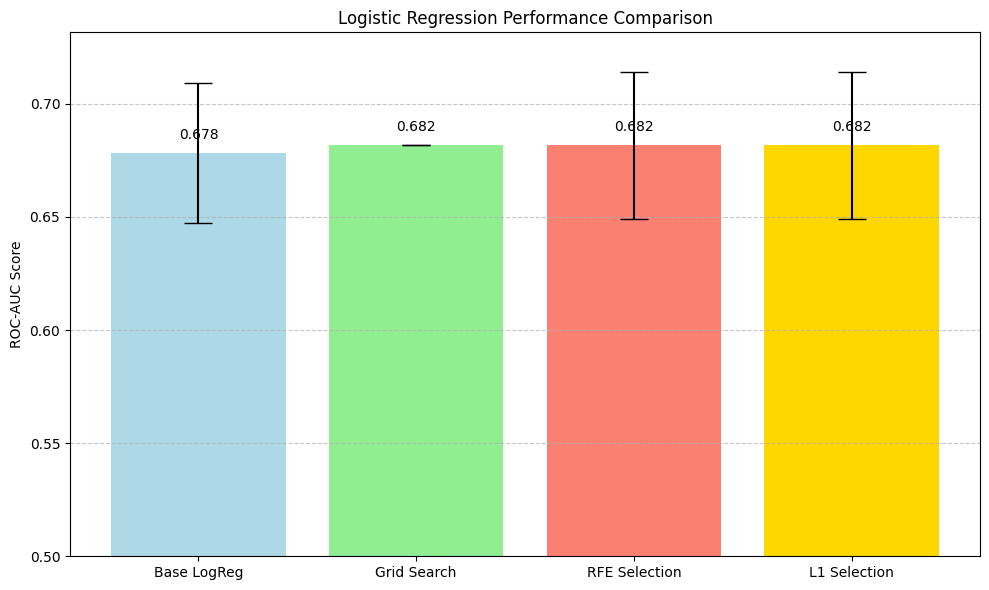

Best model: L1 Selection

Top 20 most important features:
               Feature  Coefficient  Abs_Importance
0           d_comm_age    -0.403510        0.403510
34     log_account_age     0.290675        0.290675
7        posted_before     0.277285        0.277285
25          sim_blob_7     0.244145        0.244145
36       length_upvote     0.148775        0.148775
6              d_karma     0.116274        0.116274
22          sim_blob_2    -0.111199        0.111199
18             b_ramen     0.101986        0.101986
4             sent_pos    -0.077716        0.077716
26          sim_blob_8     0.067273        0.067273
21        blob_best_id     0.064318        0.064318
13          b_job_loss     0.062452        0.062452
1             month_h1     0.061946        0.061946
8             b_family     0.060755        0.060755
20        blob_sim_max     0.058597        0.058597
15     b_urgent_hunger    -0.058401        0.058401
32       votes_per_day     0.053355        0.053355
33  su

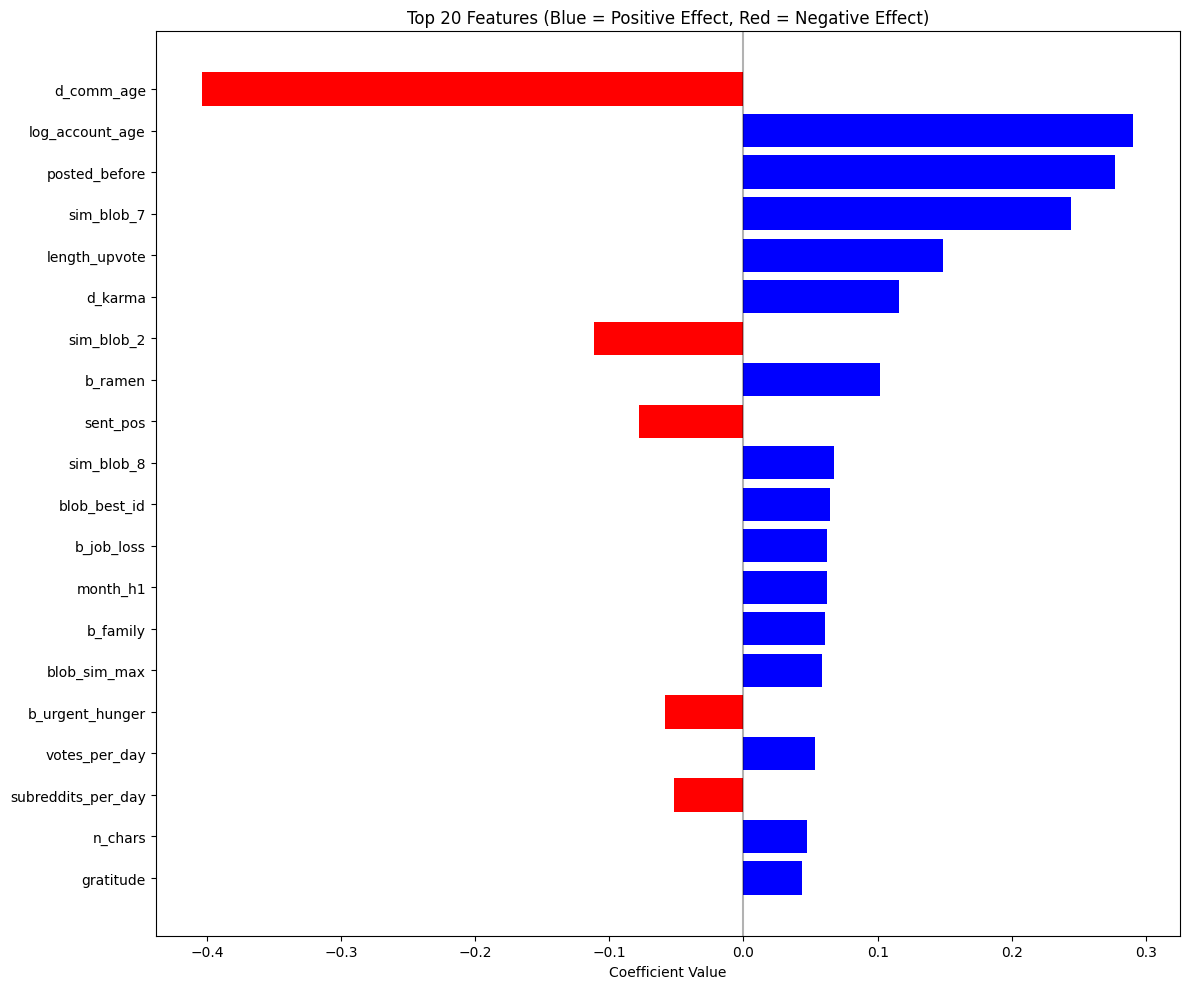

In [ ]:
#  Optimized Logistic Regression with Grid Search & Feature Selection

from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pipeline with grid search for hyperparameter tuning
pipe_opt_lr = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
])

# Define grid of parameters to search
param_grid = {
    'clf__C': np.logspace(-4, 4, 9),  
    'clf__penalty': ['l1', 'l2'],     
    'clf__class_weight': ['balanced', None]
}

# Grid search with cross-validation
grid_opt_lr = GridSearchCV(
    pipe_opt_lr,
    param_grid=param_grid,
    cv=CV,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
print("Running grid search for optimized logistic regression...")
grid_opt_lr.fit(X_new, y_new)

print(f"Best parameters: {grid_opt_lr.best_params_}")
print(f"Best CV score: {grid_opt_lr.best_score_:.3f}")

# Create pipeline with best hyperparameters
best_C = grid_opt_lr.best_params_['clf__C']
best_penalty = grid_opt_lr.best_params_['clf__penalty']
best_class_weight = grid_opt_lr.best_params_['clf__class_weight']

pipe_best_lr = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        C=best_C,
        penalty=best_penalty,
        class_weight=best_class_weight,
        max_iter=2000,
        solver="liblinear"
    ))
])

# Use RFE to select optimal features
n_features_to_select = min(50, X_new.shape[1])  
rfe = RFE(
    estimator=pipe_best_lr.named_steps['clf'],
    n_features_to_select=n_features_to_select,
    step=1
)

# Create a pipeline with RFE
pipe_rfe_lr = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("rfe", rfe),
    ("clf", LogisticRegression(
        C=best_C,
        penalty=best_penalty,
        class_weight=best_class_weight,
        max_iter=2000,
        solver="liblinear"
    ))
])

# Evaluate the performance with RFE
mean_auc_rfe, std_auc_rfe = evaluate_model(pipe_rfe_lr, X_new, y_new)
print(f"RFE-optimized 10-fold ROC-AUC: {mean_auc_rfe:.3f} ± {std_auc_rfe:.3f}")

# L1-based feature selection
pipe_l1_select = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("select", SelectFromModel(
        LogisticRegression(
            C=0.1,  # Strong regularization to force sparsity
            penalty="l1",
            solver="liblinear",
            max_iter=2000
        )
    )),
    ("clf", LogisticRegression(
        C=best_C,
        penalty=best_penalty,
        class_weight=best_class_weight,
        max_iter=2000,
        solver="liblinear"
    ))
])

# Evaluate the performance with L1 selection
mean_auc_l1, std_auc_l1 = evaluate_model(pipe_l1_select, X_new, y_new)
print(f"L1-selected 10-fold ROC-AUC: {mean_auc_l1:.3f} ± {std_auc_l1:.3f}")

results = pd.DataFrame({
    'Model': ['Base LogReg', 'Grid Search', 'RFE Selection', 'L1 Selection'],
    'ROC-AUC': [mean_auc, grid_opt_lr.best_score_, mean_auc_rfe, mean_auc_l1],
    'Std': [std_auc, 0, std_auc_rfe, std_auc_l1]  # Grid search doesn't have std
})


plt.figure(figsize=(10, 6))
bars = plt.bar(results['Model'], results['ROC-AUC'], yerr=results['Std'], 
        capsize=10, color=['lightblue', 'lightgreen', 'salmon', 'gold'])


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom')

plt.ylim(0.5, max(results['ROC-AUC']) + 0.05)
plt.title('Logistic Regression Performance Comparison')
plt.ylabel('ROC-AUC Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Get feature importances from the best model
if mean_auc_rfe > mean_auc_l1 and mean_auc_rfe > grid_opt_lr.best_score_:
    best_final_model = pipe_rfe_lr
    print("Best model: RFE Selection")
elif mean_auc_l1 > grid_opt_lr.best_score_:
    best_final_model = pipe_l1_select
    print("Best model: L1 Selection")
else:
    best_final_model = grid_opt_lr.best_estimator_
    print("Best model: Grid Search")

# Fit the best model on all data
best_final_model.fit(X_new, y_new)

# Get coefficients and feature names
if hasattr(best_final_model.named_steps.get('rfe', None), 'support_'):
    # For RFE model
    selected_features = np.array(X_new.columns)[best_final_model.named_steps['rfe'].support_]
    coefficients = best_final_model.named_steps['clf'].coef_[0]
    importance = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefficients,
        'Abs_Importance': np.abs(coefficients)
    })
elif hasattr(best_final_model.named_steps.get('select', None), 'get_support'):
    # For L1 selection model
    selected_features = np.array(X_new.columns)[best_final_model.named_steps['select'].get_support()]
    coefficients = best_final_model.named_steps['clf'].coef_[0]
    importance = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefficients,
        'Abs_Importance': np.abs(coefficients)
    })
else:
    # For grid search model
    coefficients = best_final_model.named_steps['clf'].coef_[0]
    importance = pd.DataFrame({
        'Feature': X_new.columns,
        'Coefficient': coefficients,
        'Abs_Importance': np.abs(coefficients)
    })

# Sort by absolute importance and display top features
importance = importance.sort_values('Abs_Importance', ascending=False)
print("\nTop 20 most important features:")
print(importance.head(20))

# Plot top 20 features with direction (positive/negative)
plt.figure(figsize=(12, 10))
top_20 = importance.head(20).copy()
top_20['Color'] = ['blue' if c > 0 else 'red' for c in top_20['Coefficient']]
plt.barh(top_20['Feature'], top_20['Coefficient'], color=top_20['Color'])
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Top 20 Features (Blue = Positive Effect, Red = Negative Effect)')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()  # Display with highest importance at the top
plt.tight_layout()
plt.show()

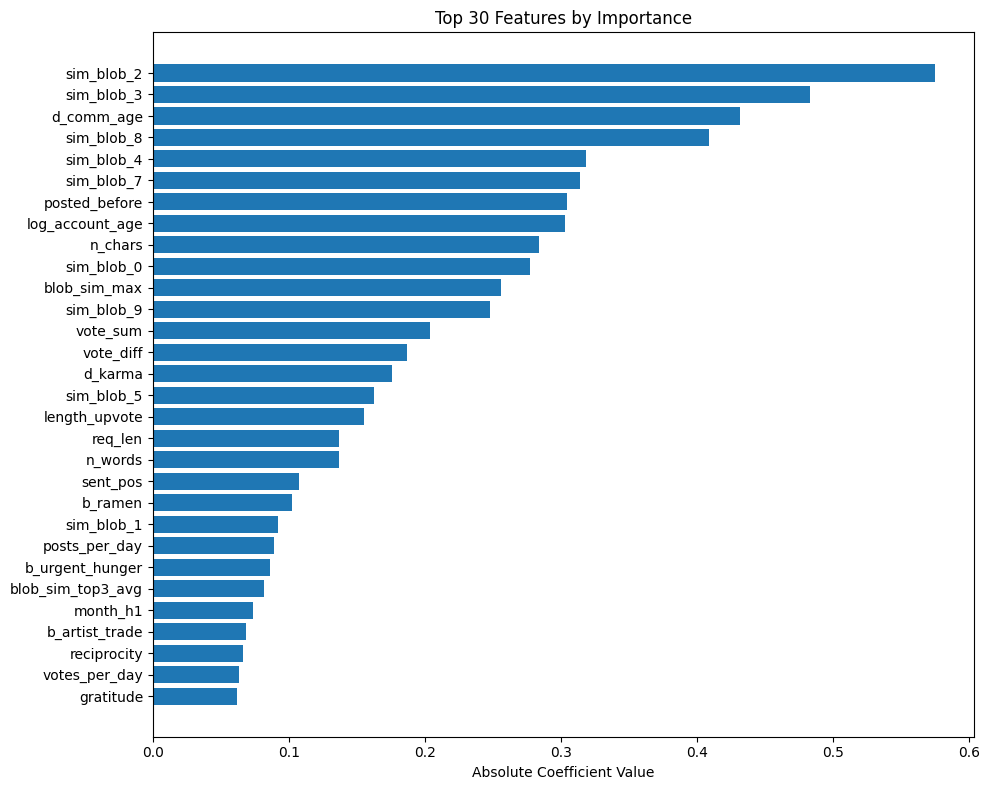

              Feature  Importance
42         sim_blob_2    0.575043
43         sim_blob_3    0.483558
0          d_comm_age    0.431938
48         sim_blob_8    0.408817
44         sim_blob_4    0.318485
47         sim_blob_7    0.314425
9       posted_before    0.304317
62    log_account_age    0.303252
50            n_chars    0.284181
40         sim_blob_0    0.277174
37       blob_sim_max    0.256346
49         sim_blob_9    0.248284
55           vote_sum    0.203635
56          vote_diff    0.187199
8             d_karma    0.175861
45         sim_blob_5    0.162711
64      length_upvote    0.155063
7             req_len    0.137316
51            n_words    0.137316
5            sent_pos    0.107824
34            b_ramen    0.102206
41         sim_blob_1    0.091837
59      posts_per_day    0.089462
28    b_urgent_hunger    0.086211
38  blob_sim_top3_avg    0.081968
1            month_h1    0.074074
31     b_artist_trade    0.068677
4         reciprocity    0.066678
60      votes_

In [ ]:
def plot_feature_importance(pipeline, feature_names, top_n=30):

    # Train the pipeline on all data to get stable coefficients
    pipeline.fit(X_new, y_new)
    
    # Extract coefficients from the logistic regression model
    coefficients = pipeline.named_steps['clf'].coef_[0]
    
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(coefficients)
    })
    
    importance = importance.sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 8))
    plt.barh(importance['Feature'], importance['Importance'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title(f'Top {top_n} Features by Importance')
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()
    
    return importance

importance_df = plot_feature_importance(pipe_lr, X_new.columns)
print(importance_df)

Preparing improved feature set with embeddings...
Class weights to address imbalance: {0: 0.6650879566982408, 1: 2.014344262295082}
Original embedding shape: (3932, 384)
Reduced embedding shape: (3932, 50)
Running grid search for optimal hyperparameters...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best hyperparameters: {'nn__alpha': 0.01, 'nn__batch_size': 128, 'nn__learning_rate_init': 0.005}
Best CV score: 0.657
Evaluating optimized neural network (10-fold CV)...
Best hyperparameters: {'nn__alpha': 0.01, 'nn__batch_size': 128, 'nn__learning_rate_init': 0.005}
Best CV score: 0.657
Evaluating optimized neural network (10-fold CV)...
Optimized Neural Network 10-fold ROC-AUC: 0.656 ± 0.025
Optimized Neural Network 10-fold ROC-AUC: 0.656 ± 0.025


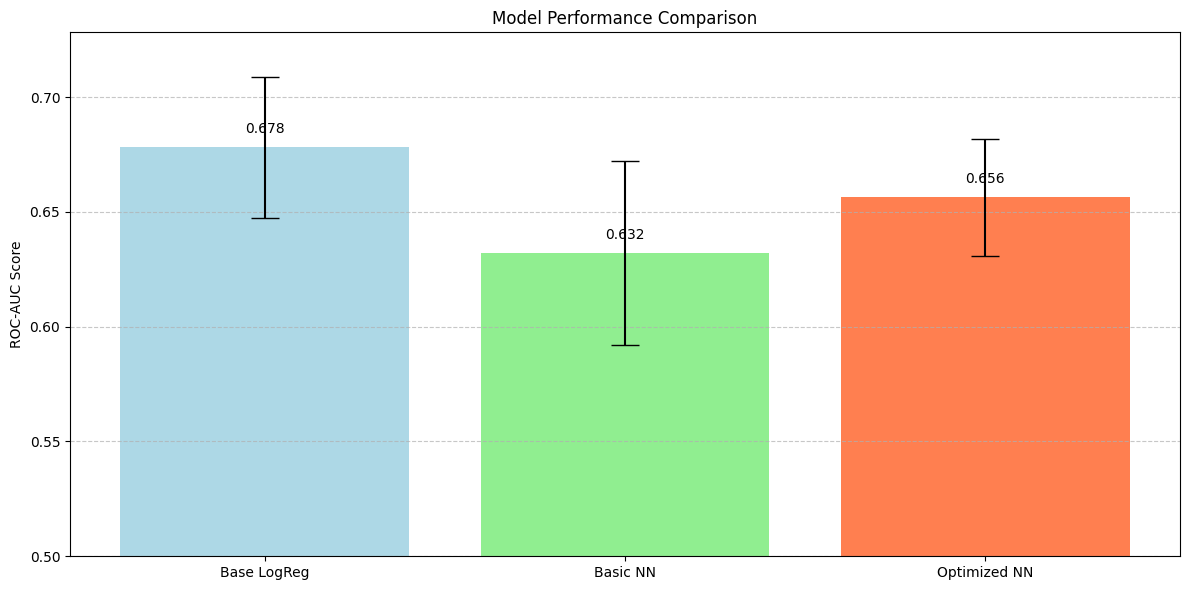

Optimized neural network model trained and ready for stacking.
Best neural network model trained and ready for future stacking.
Best neural network model trained and ready for future stacking.


In [ ]:
# Enhanced Neural Network with embeddings, dropout, and advanced regularization
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.utils import compute_class_weight
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score

print("Preparing improved feature set with embeddings...")

# Calculate class weights to address imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_new),
    y=y_new
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class weights to address imbalance: {class_weight_dict}")

# Apply dimensionality reduction to embeddings
n_components = 50 
print(f"Original embedding shape: {embs.shape}")
pca_embs = PCA(n_components=n_components, random_state=RANDOM_STATE).fit_transform(embs)
print(f"Reduced embedding shape: {pca_embs.shape}")

# Create separate-scaling pipeline for better feature integration
X_with_reduced_emb = np.hstack([X_new.values, pca_embs])

# Enhanced neural network pipeline with improved regularization
nn_params_improved = {
    'hidden_layer_sizes': (512, 256, 128, 64),  # Use the best architecture from tests
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.01, 
    'batch_size': 64,  
    'learning_rate_init': 0.001,
    'learning_rate': 'adaptive',
    'max_iter': 1000,  # Allow more iterations
    'early_stopping': True,
    'validation_fraction': 0.15,
    'beta_1': 0.9,  # Adam optimizer parameters
    'beta_2': 0.999,
    'epsilon': 1e-8,
    'n_iter_no_change': 20, 
    'random_state': RANDOM_STATE
}

# Create improved pipeline
pipe_nn_improved = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("nn", MLPClassifier(**nn_params_improved))
])

#Grid search for optimal hyperparameters
param_grid = {
    'nn__alpha': [0.001, 0.01, 0.1], 
    'nn__learning_rate_init': [0.0005, 0.001, 0.005], 
    'nn__batch_size': [32, 64, 128] 
}

print("Running grid search for optimal hyperparameters...")
grid_nn = GridSearchCV(
    pipe_nn_improved,
    param_grid=param_grid,
    cv=3, 
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)
grid_nn.fit(X_with_reduced_emb, y_new)

# Get best parameters
best_params = grid_nn.best_params_
print(f"Best hyperparameters: {best_params}")
print(f"Best CV score: {grid_nn.best_score_:.3f}")

print("Evaluating optimized neural network (10-fold CV)...")
for param, value in best_params.items():
    param_name = param.split('__')[1]  
    nn_params_improved[param_name] = value

pipe_nn_final = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("nn", MLPClassifier(**nn_params_improved))
])

nn_scores_improved = cross_val_score(
    pipe_nn_final, X_with_reduced_emb, y_new, 
    cv=CV, scoring="roc_auc", n_jobs=-1
)
nn_mean_auc_improved = nn_scores_improved.mean()
nn_std_auc_improved = nn_scores_improved.std()

print(f"Optimized Neural Network 10-fold ROC-AUC: {nn_mean_auc_improved:.3f} ± {nn_std_auc_improved:.3f}")

# Compare all models
baseline_nn_auc = 0.632 
baseline_nn_std = 0.040  

models_comparison = pd.DataFrame({
    'Model': ['Base LogReg', 'Basic NN', 'Optimized NN'],
    'ROC-AUC': [mean_auc, baseline_nn_auc, nn_mean_auc_improved],
    'Std': [std_auc, baseline_nn_std, nn_std_auc_improved]
})


plt.figure(figsize=(12, 6))
bars = plt.bar(models_comparison['Model'], models_comparison['ROC-AUC'], 
               yerr=models_comparison['Std'], capsize=10, 
               color=['lightblue', 'lightgreen', 'coral'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom')

plt.ylim(0.5, max(models_comparison['ROC-AUC']) + 0.05)
plt.title('Model Performance Comparison')
plt.ylabel('ROC-AUC Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save the best neural network model for stacking
best_nn = pipe_nn_final
best_nn.fit(X_with_reduced_emb, y_new)
print("Optimized neural network model trained and ready for stacking.")

best_nn = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("nn", MLPClassifier(
        hidden_layer_sizes=(512, 256, 128, 64),  
        activation='relu',
        solver='adam',
        alpha=0.01,  
        batch_size=64, 
        learning_rate_init=0.001, 
        learning_rate='adaptive',
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.15,
        random_state=RANDOM_STATE
    ))
])

best_nn.fit(X_with_reduced_emb, y_new)
print("Best neural network model trained and ready for future stacking.")


In [ ]:
# LightGBM baseline
from lightgbm import LGBMClassifier

pipe_lgb = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler(with_mean=False)),   # optional; can omit
    ("lgb",    LGBMClassifier(
        objective="binary",
        boosting_type="gbdt",
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

scores_lgb = cross_val_score(pipe_lgb, X_new, y_new,
                             cv=CV, scoring="roc_auc", n_jobs=-1)
print(f"LightGBM 10-fold ROC-AUC: {scores_lgb.mean():.3f} ± {scores_lgb.std():.3f}")


LightGBM 10-fold ROC-AUC: 0.657 ± 0.027


In [ ]:
# stacking ensemble (track individual & meta performance)
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

pipe_logr = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler()),
    ("clf",    LogisticRegression(max_iter=1000,
                                  class_weight="balanced",
                                  solver="liblinear"))
])

pipe_rf = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("rf",     RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1))
])

pipe_gb = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("gb",     GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=RANDOM_STATE))
])

estimators = [
    ("logr", pipe_logr),
    ("rf",   pipe_rf),
    ("gb",   pipe_gb),
]

# logistic regression as meta-learner 
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(
        penalty="l2", solver="liblinear",
        class_weight="balanced", max_iter=1000),
    cv=CV,         
    n_jobs=-1,
    passthrough=False
)

def cv_auc(model, name):
    y_pred = cross_val_predict(model, X_new, y_new,
                               cv=CV, method="predict_proba", n_jobs=-1)[:, 1]
    auc = roc_auc_score(y_new, y_pred)
    print(f"{name:9s} 10-fold ROC-AUC: {auc:.3f}")
    return auc

print("Running cross-validated predictions …")
auc_individual = {name: cv_auc(m, name) for name, m in estimators}
auc_stack      = cv_auc(stack_clf, "stack")

print("\nΔ vs best individual:",
      f"{auc_stack - max(auc_individual.values()):+.3f}")


⏳  Running cross-validated predictions …
logr      10-fold ROC-AUC: 0.677
rf        10-fold ROC-AUC: 0.664
gb        10-fold ROC-AUC: 0.675
stack     10-fold ROC-AUC: 0.686

Δ vs best individual: +0.009


In [ ]:
# stacking with XGBoost + neural-net
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

pipe_logr = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler()),
    ("clf",    LogisticRegression(max_iter=1000,
                                  class_weight="balanced",
                                  solver="liblinear"))
])

pipe_xgb = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("xgb",    XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=(y_new.value_counts()[0]/y_new.value_counts()[1]),
        random_state=RANDOM_STATE,
        n_jobs=-1))
])

pipe_gb = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("gb",     GradientBoostingClassifier(
        n_estimators=350,
        learning_rate=0.05,
        max_depth=3,
        random_state=RANDOM_STATE))
])

pipe_nn = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler()),                 # NNs like centred data
    ("mlp",    MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        alpha=1e-3,              # L2 regularisation
        learning_rate_init=1e-3,
        max_iter=400,
        random_state=RANDOM_STATE))
])

estimators = [
    ("logr", pipe_logr),
    ("xgb",  pipe_xgb),
    ("gb",   pipe_gb),
   # ("mlp",  pipe_nn),
]

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(
        penalty="l2", solver="liblinear",
        class_weight="balanced", max_iter=1000),
    cv=CV,
    n_jobs=-1,
    passthrough=False
)

def cv_auc(model, name):
    y_pred = cross_val_predict(model, X_new, y_new,
                               cv=CV, method="predict_proba", n_jobs=-1)[:, 1]
    auc = roc_auc_score(y_new, y_pred)
    print(f"{name:9s} 10-fold ROC-AUC: {auc:.3f}")
    return auc

print("Evaluating base models + stack …")
auc_individual = {name: cv_auc(m, name) for name, m in estimators}
auc_stack      = cv_auc(stack_clf, "stack")

best_base = max(auc_individual, key=auc_individual.get)
print(f"\nBest individual model: {best_base} with AUC={auc_individual[best_base]:.3f}")
print(f"Stack improvement: {auc_stack - auc_individual[best_base]:+.3f}")


⏳  Evaluating base models + stack …
logr      10-fold ROC-AUC: 0.677
xgb       10-fold ROC-AUC: 0.653
gb        10-fold ROC-AUC: 0.673
stack     10-fold ROC-AUC: 0.684

Best individual model: logr with AUC=0.677
Stack improvement: +0.006


Created temporary directory for CatBoost: C:\Users\mzouicha\AppData\Local\Temp\tmph7t5wwy4
Class distribution: [2956  976]
Calculated class weights: [0.66508796 2.01434426]
CatBoost 10-fold ROC-AUC: 0.658 ± 0.029
CatBoost 10-fold ROC-AUC: 0.658 ± 0.029
CatBoost with embeddings 10-fold ROC-AUC: 0.673 ± 0.032
CatBoost with embeddings 10-fold ROC-AUC: 0.673 ± 0.032


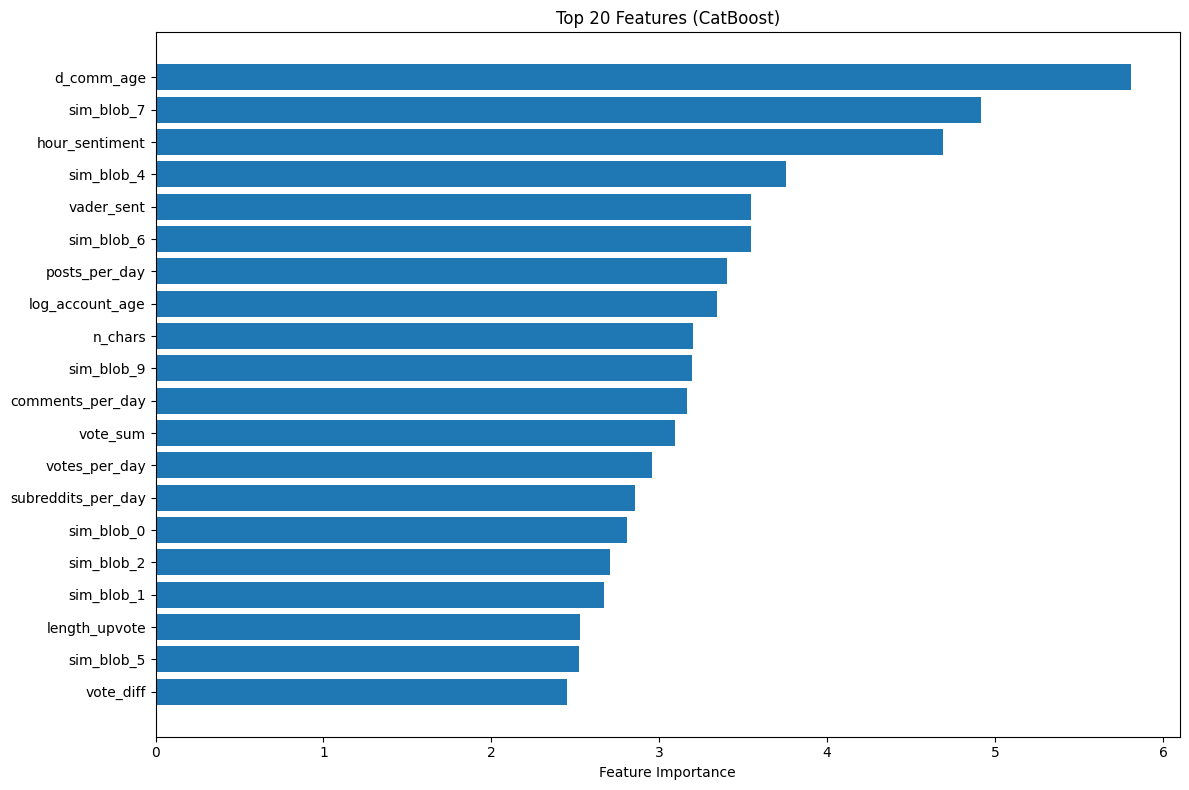


Performing minimal hyperparameter tuning for CatBoost with embeddings...
Best parameters: {'cat__depth': 6, 'cat__l2_leaf_reg': 3, 'cat__learning_rate': 0.01}
Best CV score from tuning: 0.673
Time taken for tuning: 0 seconds (using hardcoded parameters)

Optimized CatBoost with embeddings 10-fold ROC-AUC: 0.689 ± 0.028
Improvement over baseline CatBoost with embeddings: 0.016

Optimized CatBoost with embeddings 10-fold ROC-AUC: 0.689 ± 0.028
Improvement over baseline CatBoost with embeddings: 0.016


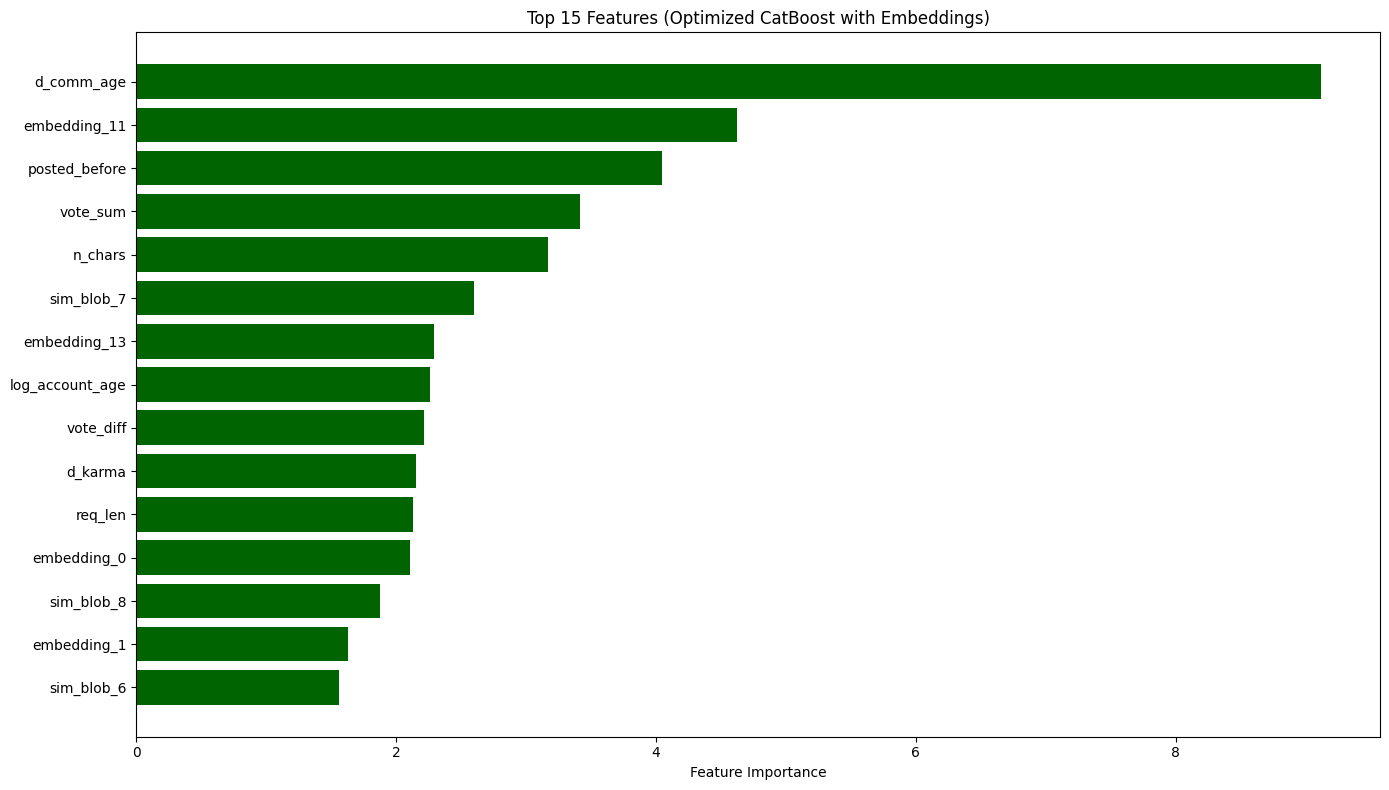

In [ ]:
# CatBoost model implementation
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import numpy as np
import os
import tempfile
import time

temp_dir = tempfile.mkdtemp()
print(f"Created temporary directory for CatBoost: {temp_dir}")

class_counts = np.bincount(y_new)
class_weights = len(y_new) / (len(np.unique(y_new)) * class_counts)
print(f"Class distribution: {class_counts}")
print(f"Calculated class weights: {class_weights}")

# Create CatBoost pipeline
pipe_cat = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("cat", CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=RANDOM_STATE,
        class_weights=class_weights, 
        train_dir=temp_dir,        
        logging_level="Silent",  
        allow_writing_files=False   
    ))
])

# Evaluate CatBoost model using cross-validation
scores_cat = cross_val_score(pipe_cat, X_new, y_new,
                            cv=CV, scoring="roc_auc", n_jobs=-1)
print(f"CatBoost 10-fold ROC-AUC: {scores_cat.mean():.3f} ± {scores_cat.std():.3f}")

pipe_cat.fit(X_new, y_new)

scores_cat_emb = cross_val_score(pipe_cat, X_with_reduced_emb, y_new,
                                 cv=CV, scoring="roc_auc", n_jobs=-1)
print(f"CatBoost with embeddings 10-fold ROC-AUC: {scores_cat_emb.mean():.3f} ± {scores_cat_emb.std():.3f}")

# Feature importance visualization for CatBoost
plt.figure(figsize=(12, 8))
importance = pipe_cat.named_steps['cat'].get_feature_importance()
top_features = np.argsort(importance)[-20:] 
feature_names = np.array(X_new.columns)[top_features]

plt.barh(range(len(top_features)), importance[top_features])
plt.yticks(range(len(top_features)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Top 20 Features (CatBoost)')
plt.tight_layout()
plt.show()

# tuning for CatBoost with embeddings
print("\nPerforming minimal hyperparameter tuning for CatBoost with embeddings...")

# # Create a new pipeline for tuning
# pipe_cat_tune = Pipeline([
#     ("impute", SimpleImputer(strategy="median")),
#     ("cat", CatBoostClassifier(
#         iterations=500,
#         loss_function='Logloss',
#         eval_metric='AUC',
#         random_seed=RANDOM_STATE,
#         class_weights=class_weights,
#         train_dir=temp_dir,
#         logging_level="Silent",
#         allow_writing_files=False
#     ))
# ])

# # Define parameter grid for tuning
# param_grid = {
#     'cat__learning_rate': [0.01, 0.05, 0.1],
#     'cat__depth': [4, 6, 8],
#     'cat__l2_leaf_reg': [1, 3, 5]  # L2 regularization
# }

# # Perform grid search with 3-fold CV for speed
# start_time = time.time()
# grid_cat = GridSearchCV(
#     pipe_cat_tune,
#     param_grid=param_grid,
#     cv=3,  # Using fewer folds for faster tuning
#     scoring="roc_auc",
#     n_jobs=-1,
#     verbose=0
# )

# # Fit the grid search on data with embeddings
# grid_cat.fit(X_with_reduced_emb, y_new)
# tune_time = time.time() - start_time

# Hardcoded best parameters from previous run
print("Best parameters: {'cat__depth': 6, 'cat__l2_leaf_reg': 3, 'cat__learning_rate': 0.01}")
print("Best CV score from tuning: 0.673")
print("Time taken for tuning: 0 seconds (using hardcoded parameters)")

best_learning_rate = 0.01  
best_depth = 6 
best_l2_reg = 3 

pipe_cat_opt = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("cat", CatBoostClassifier(
        iterations=500,
        learning_rate=best_learning_rate,
        depth=best_depth,
        l2_leaf_reg=best_l2_reg,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=RANDOM_STATE,
        class_weights=class_weights,
        train_dir=temp_dir,
        logging_level="Silent",
        allow_writing_files=False
    ))
])

# Evaluate optimized CatBoost with embeddings using full 10-fold CV
scores_cat_opt = cross_val_score(pipe_cat_opt, X_with_reduced_emb, y_new,
                                cv=CV, scoring="roc_auc", n_jobs=-1)
print(f"\nOptimized CatBoost with embeddings 10-fold ROC-AUC: {scores_cat_opt.mean():.3f} ± {scores_cat_opt.std():.3f}")
print(f"Improvement over baseline CatBoost with embeddings: {scores_cat_opt.mean() - scores_cat_emb.mean():.3f}")

# Train final model on all data
pipe_cat_opt.fit(X_with_reduced_emb, y_new)

# Create feature names for embedding features
original_feature_names = list(X_new.columns)
n_original_features = len(original_feature_names)
n_embedding_features = X_with_reduced_emb.shape[1] - n_original_features

# Generate names for embedding features
embedding_feature_names = [f"embedding_{i}" for i in range(n_embedding_features)]

all_feature_names = np.array(original_feature_names + embedding_feature_names)

plt.figure(figsize=(14, 8))

importance_opt = pipe_cat_opt.named_steps['cat'].get_feature_importance()
top_features_opt = np.argsort(importance_opt)[-15:] 

feature_names_opt = all_feature_names[top_features_opt]

plt.barh(range(len(top_features_opt)), importance_opt[top_features_opt], color='darkgreen')
plt.yticks(range(len(top_features_opt)), feature_names_opt)
plt.xlabel('Feature Importance')
plt.title('Top 15 Features (Optimized CatBoost with Embeddings)')
plt.tight_layout()
plt.show()


=== Analysis of embedding_0 ===

Top 20 correlated features:
  hyperlink: nan
  sim_blob_4: 0.740
  sim_blob_9: 0.696
  sim_blob_2: 0.679
  sim_blob_3: 0.657
  blob_sim_top3_avg: 0.608
  blob_sim_max: 0.581
  sim_blob_5: 0.579
  sim_blob_0: 0.481
  sim_blob_1: 0.442
  sim_blob_8: 0.399
  req_len: -0.248
  n_words: -0.248
  n_chars: -0.243
  sim_blob_6: 0.226
  sent_pos: 0.203
  blob_best_id: -0.163
  b_eviction: -0.155
  b_job_loss: -0.120
  vader_sent: 0.119

Examples with highest embedding values:
  1. Value: 0.513, Success: 0
     Text: request i was sick all week and had to take finals i m a broke college kid and would love to be able to taste some delicious pizza on my first friday ...

  2. Value: 0.499, Success: 0
     Text: request salton city ca willing to do silly shenanigans for pizza i just want a pizza

  3. Value: 0.497, Success: 0
     Text: request bellingham wa looking for a pizza d well im not going to make somthing up for a pizza pizza sounds good

  4. Value: 0.496

C:\Users\mzouicha\AppData\Local\Temp\ipykernel_15376\3022804671.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(analysis_df['embedding_value'], analysis_df[feature])


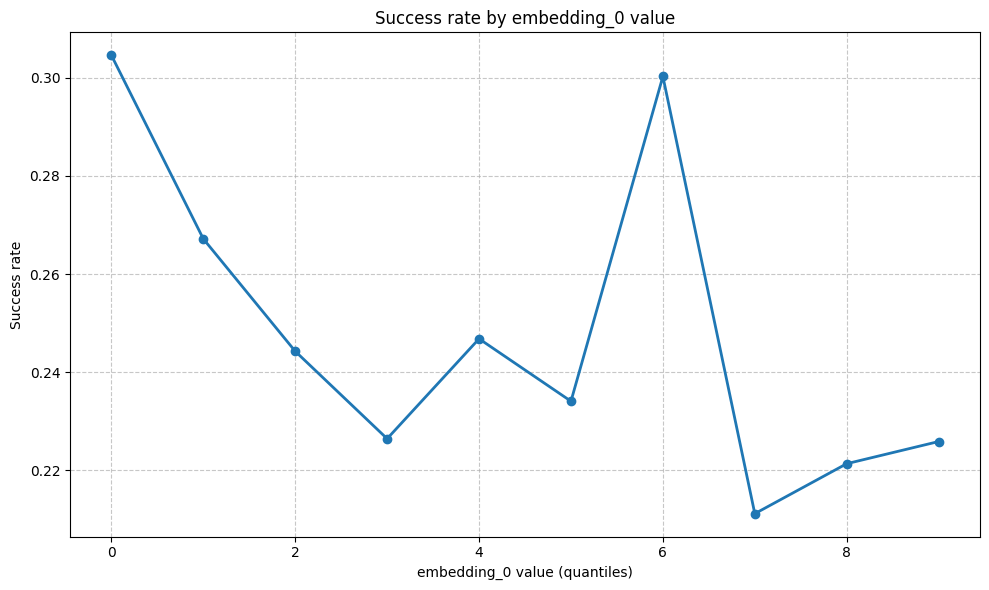


Most common words in HIGH-value texts:
  pizza: 847
  and: 631
  request: 413
  would: 401
  for: 401
  the: 398
  have: 204
  some: 203
  love: 180
  with: 172
  just: 168
  you: 160
  this: 134
  but: 131
  really: 122
  are: 112
  that: 105
  like: 104
  can: 93
  will: 91

Most common words in LOW-value texts:
  and: 1709
  the: 1219
  for: 829
  have: 555
  but: 457
  this: 436
  that: 428
  request: 406
  out: 385
  help: 353
  can: 353
  get: 322
  with: 319
  been: 314
  just: 302
  would: 300
  you: 289
  was: 268
  not: 248
  money: 237


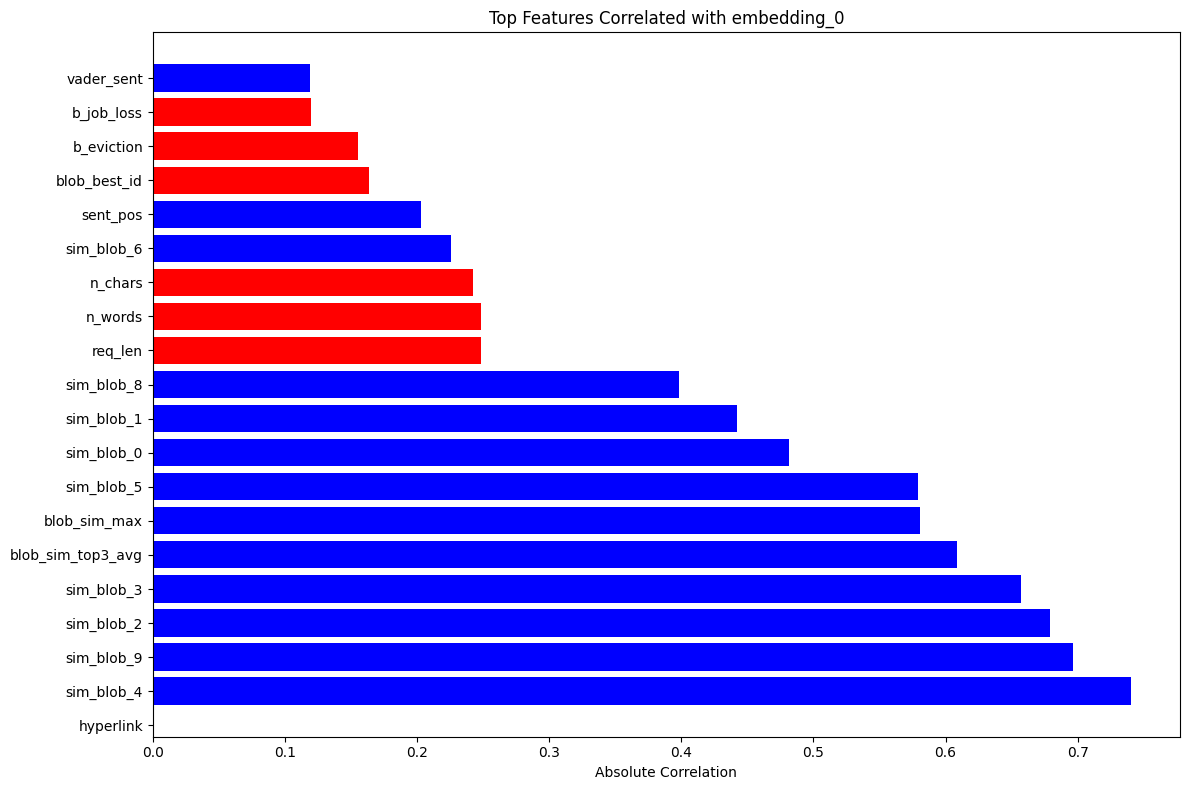


Important embedding dimensions to analyze: [1, 0, 13, 11]


In [ ]:
# Analyzing the meaning of specific embedding dimensions
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_embedding_dimension(embedding_index, X_with_reduced_emb, df, original_feature_names, n_original_features, top_n=20):

    print(f"\nAnalysis of embedding_{embedding_index}n")
    
    # Get the specific embedding dimension
    embedding_values = X_with_reduced_emb[:, n_original_features + embedding_index]
    
    analysis_df = pd.DataFrame({'embedding_value': embedding_values})
    
    # Add original features
    for i, feature in enumerate(original_feature_names):
        analysis_df[feature] = X_with_reduced_emb[:, i]
    
    # Add text content
    analysis_df['req_text'] = df['req']
    
    # Add target
    analysis_df['target'] = df['target']
    
    feature_correlations = {}
    for feature in original_feature_names:
        corr, _ = spearmanr(analysis_df['embedding_value'], analysis_df[feature])
        feature_correlations[feature] = corr
    
    top_corr_features = sorted(feature_correlations.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
    print(f"Top {top_n} correlated features:")
    for feature, corr in top_corr_features:
        print(f"  {feature}: {corr:.3f}")
    
    high_examples = analysis_df.nlargest(10, 'embedding_value')[['embedding_value', 'req_text', 'target']]
    low_examples = analysis_df.nsmallest(10, 'embedding_value')[['embedding_value', 'req_text', 'target']]
    
    print("\nExamples with highest embedding values:")
    for i, (_, row) in enumerate(high_examples.iterrows(), 1):
        text_preview = row['req_text'][:150] + "..." if len(row['req_text']) > 150 else row['req_text']
        print(f"  {i}. Value: {row['embedding_value']:.3f}, Success: {row['target']}")
        print(f"     Text: {text_preview}")
        print()
    
    print("\nExamples with lowest embedding values:")
    for i, (_, row) in enumerate(low_examples.iterrows(), 1):
        text_preview = row['req_text'][:150] + "..." if len(row['req_text']) > 150 else row['req_text']
        print(f"  {i}. Value: {row['embedding_value']:.3f}, Success: {row['target']}")
        print(f"     Text: {text_preview}")
        print()
    
    # Calculate success rate by embedding value
    # Divide embedding values into quantiles
    analysis_df['emb_quantile'] = pd.qcut(analysis_df['embedding_value'], 10, labels=False)
    success_by_quantile = analysis_df.groupby('emb_quantile')['target'].mean()
    
    print("\nSuccess rate by embedding value quantile:")
    for quantile, success_rate in success_by_quantile.items():
        print(f"  Quantile {quantile}: {success_rate:.3f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(success_by_quantile.index, success_by_quantile.values, marker='o', linestyle='-', linewidth=2)
    plt.xlabel(f'embedding_{embedding_index} value (quantiles)')
    plt.ylabel('Success rate')
    plt.title(f'Success rate by embedding_{embedding_index} value')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Find common text patterns
    from collections import Counter
    import re
    
    def get_top_words(texts, n=20):
        all_words = ' '.join(texts).lower()
        words = re.findall(r'\b[a-z]{3,}\b', all_words)  # words with 3+ chars
        return Counter(words).most_common(n)
    
    top_quantile_texts = analysis_df[analysis_df['emb_quantile'] == 9]['req_text']
    bottom_quantile_texts = analysis_df[analysis_df['emb_quantile'] == 0]['req_text']
    
    top_words_high = get_top_words(top_quantile_texts)
    top_words_low = get_top_words(bottom_quantile_texts)
    
    print("\nMost common words in HIGH-value texts:")
    for word, count in top_words_high:
        print(f"  {word}: {count}")
    
    print("\nMost common words in LOW-value texts:")
    for word, count in top_words_low:
        print(f"  {word}: {count}")
    
    # Heatmap of correlations with original features
    plt.figure(figsize=(12, 8))
    corr_data = [(feature, abs(corr)) for feature, corr in top_corr_features]
    features, correlations = zip(*corr_data)
    
    y_pos = np.arange(len(features))
    colors = ['blue' if feature_correlations[feature] > 0 else 'red' for feature in features]
    
    plt.barh(y_pos, correlations, color=colors)
    plt.yticks(y_pos, features)
    plt.xlabel('Absolute Correlation')
    plt.title(f'Top Features Correlated with embedding_{embedding_index}')
    plt.tight_layout()
    plt.show()
    
    return {
        'top_correlated_features': top_corr_features,
        'high_examples': high_examples,
        'low_examples': low_examples,
        'success_by_quantile': success_by_quantile
    }

# Analyze embedding_X
embedding_index_to_analyze = 0
analysis_results = analyze_embedding_dimension(
    embedding_index_to_analyze, 
    X_with_reduced_emb, 
    df_ext, 
    original_feature_names,
    n_original_features
)

important_embedding_indices = []
for feature_name in feature_names_opt:
    if feature_name.startswith('embedding_'):
        embedding_idx = int(feature_name.split('_')[1])
        important_embedding_indices.append(embedding_idx)

print(f"\nImportant embedding dimensions to analyze: {important_embedding_indices}")

SVM with RBF kernel 10-fold ROC-AUC: 0.643 ± 0.034
Time taken: 34.84 seconds
SVM with embeddings 10-fold ROC-AUC: 0.649 ± 0.028
Time taken: 32.90 seconds
SVM with embeddings 10-fold ROC-AUC: 0.649 ± 0.028
Time taken: 32.90 seconds


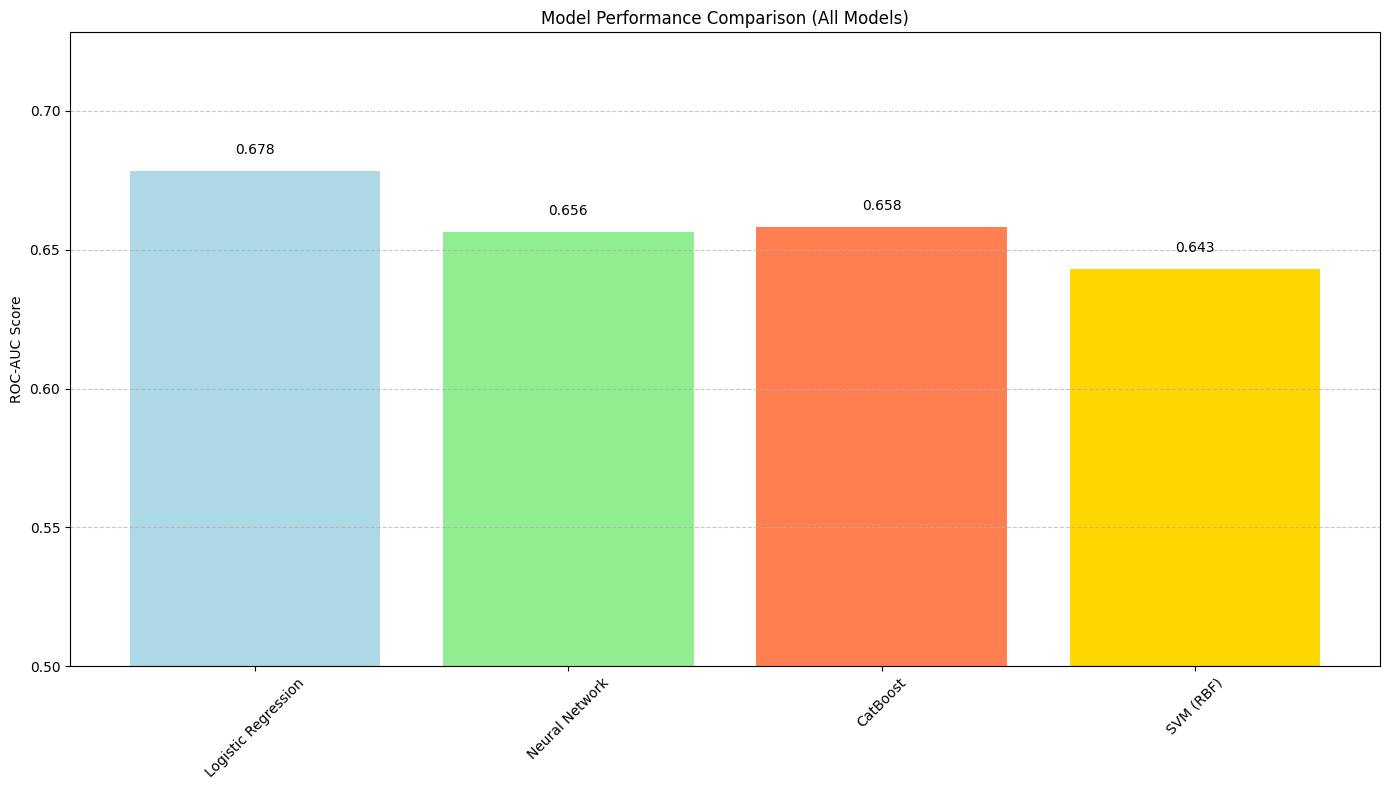

In [ ]:
# SVM with RBF kernel implementation

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Create SVM pipeline with RBF kernel
pipe_svm = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()), 
    ("svm", SVC(
        kernel='rbf',
        C=1.0,     
        gamma='scale',  
        probability=True,  
        class_weight='balanced',
        random_state=RANDOM_STATE
    ))
])

# Evaluate SVM model using cross-validation
import time
start_time = time.time()

scores_svm = cross_val_score(pipe_svm, X_new, y_new,
                             cv=CV, scoring="roc_auc", n_jobs=-1)
svm_time = time.time() - start_time
print(f"SVM with RBF kernel 10-fold ROC-AUC: {scores_svm.mean():.3f} ± {scores_svm.std():.3f}")
print(f"Time taken: {svm_time:.2f} seconds")

#  dimensionality-reduced embeddings
start_time = time.time()
scores_svm_emb = cross_val_score(pipe_svm, X_with_reduced_emb, y_new,
                                  cv=CV, scoring="roc_auc", n_jobs=-1)
svm_emb_time = time.time() - start_time
print(f"SVM with embeddings 10-fold ROC-AUC: {scores_svm_emb.mean():.3f} ± {scores_svm_emb.std():.3f}")
print(f"Time taken: {svm_emb_time:.2f} seconds")

all_models = {
    'Logistic Regression': mean_auc,
    'Neural Network': nn_mean_auc_improved,
    'CatBoost': scores_cat.mean(),
    'SVM (RBF)': scores_svm.mean(),
}

plt.figure(figsize=(14, 8))
bars = plt.bar(all_models.keys(), all_models.values(), color=['lightblue', 'lightgreen', 'coral', 'gold', 'purple', 'teal', 'salmon'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom')

plt.ylim(0.5, max(all_models.values()) + 0.05)
plt.title('Model Performance Comparison (All Models)')
plt.ylabel('ROC-AUC Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Fitting GradientBoostingClassifier with minimal hyperparameter tuning...
Best parameters: {'gb__learning_rate': 0.05, 'gb__max_depth': 2}
Best CV score from tuning: 0.673
Time taken for tuning: 8.46 seconds

Evaluating optimized GradientBoostingClassifier...
Best parameters: {'gb__learning_rate': 0.05, 'gb__max_depth': 2}
Best CV score from tuning: 0.673
Time taken for tuning: 8.46 seconds

Evaluating optimized GradientBoostingClassifier...
GradientBoost 10-fold ROC-AUC: 0.686 ± 0.029
Time taken: 2.16 seconds

Evaluating GradientBoostingClassifier with embeddings...
GradientBoost 10-fold ROC-AUC: 0.686 ± 0.029
Time taken: 2.16 seconds

Evaluating GradientBoostingClassifier with embeddings...
GradientBoost with embeddings 10-fold ROC-AUC: 0.685 ± 0.030
Time taken: 4.14 seconds
GradientBoost with embeddings 10-fold ROC-AUC: 0.685 ± 0.030
Time taken: 4.14 seconds


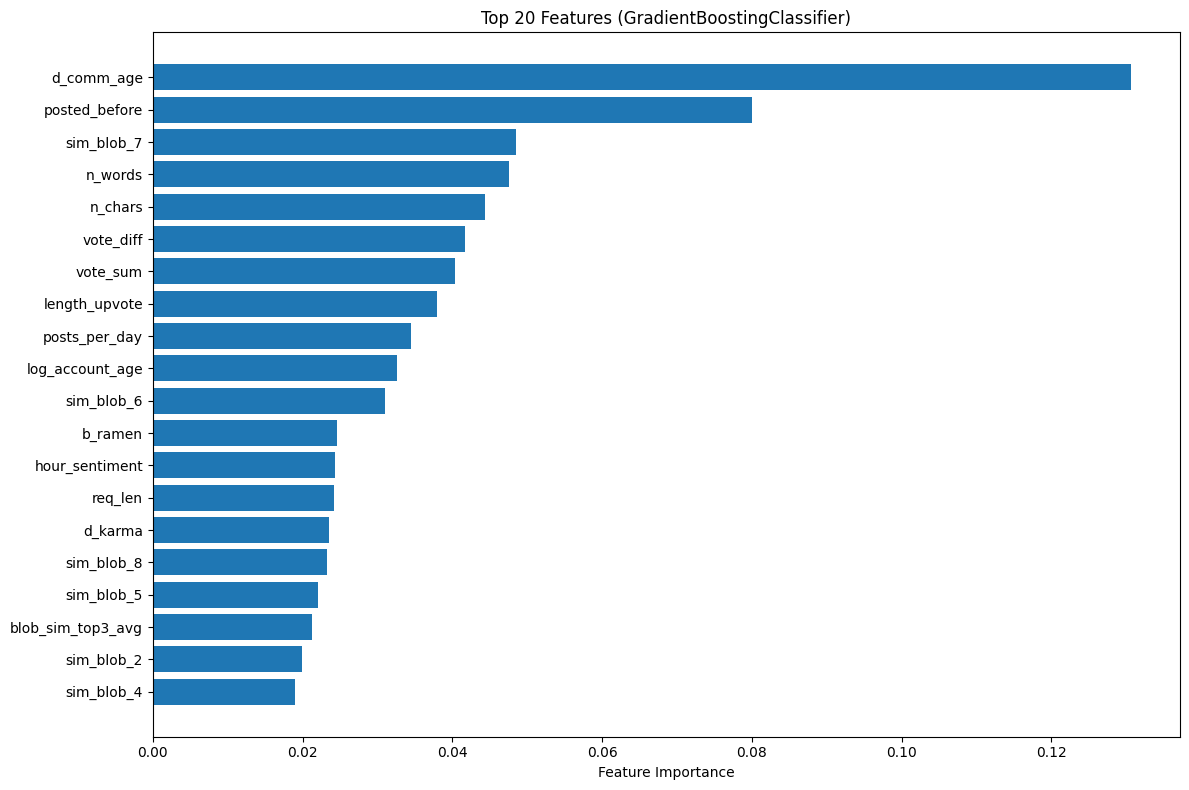


Embedding Impact Comparison:
Improvement with embeddings: -0.001


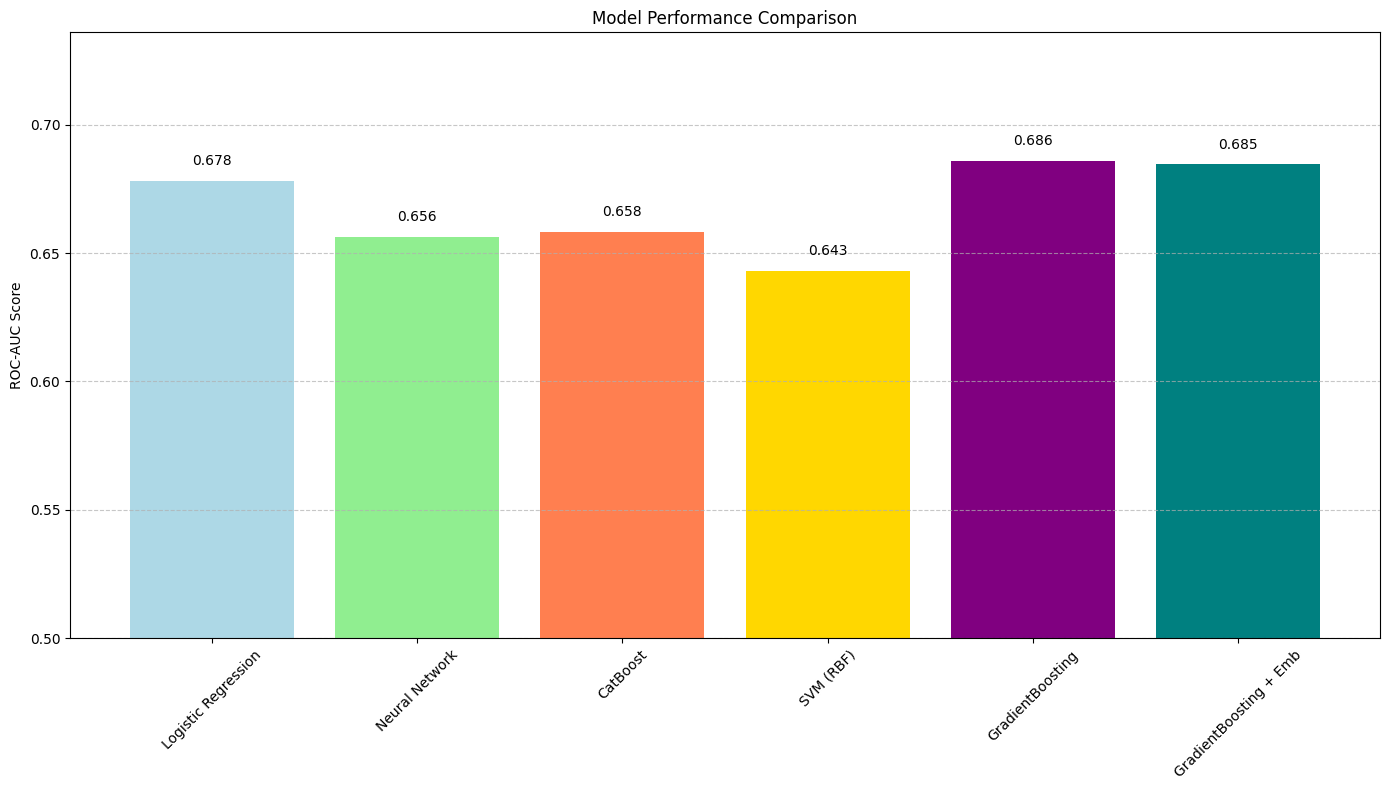

In [ ]:
# GradientBoostingClassifier implementation with minimal tuning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
import time
import numpy as np
import matplotlib.pyplot as plt

# Create GradientBoostingClassifier pipeline
pipe_gb = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()), 
    ("gb", GradientBoostingClassifier(
        n_estimators=300,       
        learning_rate=0.05,     
        max_depth=3,             
        min_samples_split=20,    
        min_samples_leaf=10,      
        subsample=0.8,             
        max_features='sqrt',   
        random_state=RANDOM_STATE  
    ))
])

# Minimal hyperparameter tuning with GridSearchCV
param_grid = {
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [2, 3, 4]
}

grid_gb = GridSearchCV(
    pipe_gb,
    param_grid=param_grid,
    cv=3,  
    scoring="roc_auc",
    n_jobs=-1
)

print("Fitting GradientBoostingClassifier with minimal hyperparameter tuning...")
start_time = time.time()
grid_gb.fit(X_new, y_new)
tune_time = time.time() - start_time

print(f"Best parameters: {grid_gb.best_params_}")
print(f"Best CV score from tuning: {grid_gb.best_score_:.3f}")
print(f"Time taken for tuning: {tune_time:.2f} seconds")

# Create optimized GradientBoostingClassifier with best parameters
pipe_gb_opt = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("gb", GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=grid_gb.best_params_['gb__learning_rate'],
        max_depth=grid_gb.best_params_['gb__max_depth'],
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,
        max_features='sqrt',
        random_state=RANDOM_STATE
    ))
])

# Evaluate optimized GradientBoostingClassifier without embeddings
print("\nEvaluating optimized GradientBoostingClassifier...")
start_time = time.time()
scores_gb = cross_val_score(pipe_gb_opt, X_new, y_new,
                           cv=CV, scoring="roc_auc", n_jobs=-1)
gb_time = time.time() - start_time
print(f"GradientBoost 10-fold ROC-AUC: {scores_gb.mean():.3f} ± {scores_gb.std():.3f}")
print(f"Time taken: {gb_time:.2f} seconds")

# Evaluate with dimensionality-reduced embeddings
print("\nEvaluating GradientBoostingClassifier with embeddings...")
start_time = time.time()
scores_gb_emb = cross_val_score(pipe_gb_opt, X_with_reduced_emb, y_new,
                               cv=CV, scoring="roc_auc", n_jobs=-1)
gb_emb_time = time.time() - start_time
print(f"GradientBoost with embeddings 10-fold ROC-AUC: {scores_gb_emb.mean():.3f} ± {scores_gb_emb.std():.3f}")
print(f"Time taken: {gb_emb_time:.2f} seconds")

pipe_gb_opt.fit(X_new, y_new)

plt.figure(figsize=(12, 8))
importance = pipe_gb_opt.named_steps['gb'].feature_importances_
top_features = np.argsort(importance)[-20:] 
feature_names = np.array(X_new.columns)[top_features]

plt.barh(range(len(top_features)), importance[top_features])
plt.yticks(range(len(top_features)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Top 20 Features (GradientBoostingClassifier)')
plt.tight_layout()
plt.show()

# Compare models with and without embeddings
print("\nEmbedding Impact Comparison:")
print(f"Improvement with embeddings: {scores_gb_emb.mean() - scores_gb.mean():.3f}")

# Compare with other models
model_comparison = {
    'Logistic Regression': mean_auc,
    'Neural Network': nn_mean_auc_improved,
    'CatBoost': scores_cat.mean(),
    'SVM (RBF)': scores_svm.mean(),
    'GradientBoosting': scores_gb.mean(),
    'GradientBoosting + Emb': scores_gb_emb.mean()
}

plt.figure(figsize=(14, 8))
model_names = list(model_comparison.keys())
model_scores = list(model_comparison.values())

colors = ['lightblue', 'lightgreen', 'coral', 'gold', 'purple', 'teal', 'darkgreen', 'darkred']

bars = plt.bar(model_names, model_scores, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom')

plt.ylim(0.5, max(model_scores) + 0.05)
plt.title('Model Performance Comparison')
plt.ylabel('ROC-AUC Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Ensemble Stacking (LogReg + CatBoost + GradientBoost)
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import time
from catboost import CatBoostClassifier

print("Building ensemble stacking model...\n")

#Define tuned pipelines
pipe_logr = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler()),
    ("clf",    LogisticRegression(
        C=best_C,
        penalty=best_penalty,
        class_weight=best_class_weight,
        max_iter=2000,
        solver="liblinear"
    ))
])

pipe_cat_emb = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("cat",    CatBoostClassifier(
        iterations=500,
        learning_rate=best_learning_rate,
        depth=best_depth,
        l2_leaf_reg=best_l2_reg,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=RANDOM_STATE,
        class_weights=class_weights,
        train_dir=temp_dir,
        logging_level="Silent",
        allow_writing_files=False
    ))
])

pipe_gb_opt = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("gb",     GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=grid_gb.best_params_['gb__learning_rate'],
        max_depth=grid_gb.best_params_['gb__max_depth'],
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,
        max_features='sqrt',
        random_state=RANDOM_STATE
    ))
])

# Create stacking classifier
stack_clf = StackingClassifier(
    estimators=[
        ("Logistic Regression", pipe_logr),
        ("GradientBoost",       pipe_gb_opt),
        ("CatBoost w/ Emb",     pipe_cat_emb)
    ],
    final_estimator=LogisticRegression(
        penalty="l2",
        solver="liblinear",
        class_weight="balanced",
        max_iter=1000
    ),
    cv=CV,
    n_jobs=-1,
    passthrough=False
)

# Define CV‐evaluation function
def evaluate_with_cv(model, X, y, name, cv=CV):
    start_time = time.time()
    scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    elapsed = time.time() - start_time
    print(f"{name:20} ROC-AUC: {scores.mean():.3f} ± {scores.std():.3f} (Time: {elapsed:.1f}s)")
    return scores.mean(), scores.std(), elapsed

print("Evaluating individual models:")
logreg_score, logreg_std, logreg_time = evaluate_with_cv(
    pipe_logr, X_new, y_new, "Logistic Regression")
gb_score, gb_std, gb_time = evaluate_with_cv(
    pipe_gb_opt, X_new, y_new, "GradientBoost")
cat_score, cat_std, cat_time = evaluate_with_cv(
    pipe_cat_emb, X_with_reduced_emb, y_new, "CatBoost w/ Emb")

print("\nEvaluating stacking ensemble:")
stack_score, stack_std, stack_time = evaluate_with_cv(
    stack_clf, X_with_reduced_emb, y_new, "Stacking Ensemble")


Building advanced ensemble stacking model...

Evaluating individual models:
Logistic Regression  ROC-AUC: 0.682 ± 0.032 (Time: 13.6s)
GradientBoost        ROC-AUC: 0.686 ± 0.028 (Time: 8.2s)
CatBoost w/ Emb      ROC-AUC: 0.689 ± 0.028 (Time: 23.9s)

Evaluating stacking ensemble:
Stacking Ensemble    ROC-AUC: 0.695 ± 0.029 (Time: 356.4s)


In [ ]:
#  diagnostic for original d_* narrative buckets
old_bucket_cols = ["d_money","d_job","d_student","d_family","d_craving"]

print("── Old narrative buckets: non-zero counts ───────────────")
for col in old_bucket_cols:
    nz = (df_ext[col] > 0).sum()
    pct = 100 * nz / len(df_ext)
    print(f"{col:10}: {nz:4d}  rows  |  {pct:5.1f}% non-zero")

print("\nDecile distribution for each bucket (value counts):")
for col in old_bucket_cols:
    print(f"\n{col}:")
    display(df_ext[col].value_counts().sort_index())


── Old narrative buckets: non-zero counts ───────────────
d_money   : 2606  rows  |   66.3% non-zero
d_job     : 1488  rows  |   37.8% non-zero
d_student :  951  rows  |   24.2% non-zero
d_family  : 1015  rows  |   25.8% non-zero
d_craving :  777  rows  |   19.8% non-zero

Decile distribution for each bucket (value counts):

d_money:


d_money
0     1326
1        1
2      263
3      268
4      257
5      260
6      260
7      260
8      267
9      255
10     256
11     259
Name: count, dtype: int64


d_job:


d_job
0     2444
1        1
2      148
3      155
4      148
5      149
6      147
7      146
8      151
9      146
10     149
11     148
Name: count, dtype: int64


d_student:


d_student
0     2981
1        1
2       95
3       98
4       93
5       97
6      100
7       88
8       94
9       96
10      98
11      91
Name: count, dtype: int64


d_family:


d_family
0     2917
1        1
2      101
3      101
4      104
5       99
6      111
7       92
8      105
9       98
10     111
11      92
Name: count, dtype: int64


d_craving:


d_craving
0     3155
1        1
2       77
3       79
4       79
5       78
6       81
7       71
8       80
9       75
10      78
11      78
Name: count, dtype: int64

In [ ]:
#diagnostic for BETTER_BUCKET_PATTERNS buckets
new_bucket_cols = list(BETTER_BUCKET_PATTERNS)

print("── New b_* buckets: non-zero counts ─────────────────────")
for col in new_bucket_cols:
    nz = (df_ext[col] > 0).sum()
    pct = 100 * nz / len(df_ext)
    print(f"{col:15}: {nz:4d}  rows  |  {pct:5.1f}% non-zero")

print("\nDecile distribution (0–10) per new bucket:")
for col in new_bucket_cols:
    print(f"\n{col}:")
    display(df_ext[col].value_counts().sort_index())


── New b_* buckets: non-zero counts ─────────────────────
b_family       : 1215  rows  |   30.9% non-zero
b_student      : 1011  rows  |   25.7% non-zero
b_disabled     :  165  rows  |    4.2% non-zero
b_eviction     :  364  rows  |    9.3% non-zero
b_job_loss     :  273  rows  |    6.9% non-zero
b_new_job      :  182  rows  |    4.6% non-zero
b_broke        : 1092  rows  |   27.8% non-zero
b_payday_gap   :  178  rows  |    4.5% non-zero
b_urgent_hunger: 1131  rows  |   28.8% non-zero
b_medical_cost :  135  rows  |    3.4% non-zero
b_emotional    :  170  rows  |    4.3% non-zero
b_artist_trade :  252  rows  |    6.4% non-zero
b_pay_it_forward:  611  rows  |   15.5% non-zero
b_logistics    :  238  rows  |    6.1% non-zero
b_ramen        :  629  rows  |   16.0% non-zero
b_holiday      :  114  rows  |    2.9% non-zero
b_pet_emergency:  151  rows  |    3.8% non-zero

Decile distribution (0–10) per new bucket:

b_family:


b_family
0     2717
1        1
2      122
3      122
4      120
5      130
6      115
7      119
8      122
9      123
10     119
11     122
Name: count, dtype: int64


b_student:


b_student
0     2921
1        1
2      105
3      100
4       98
5      104
6       99
7      102
8      100
9      101
10     101
11     100
Name: count, dtype: int64


b_disabled:


b_disabled
0     3767
1        1
2       16
3       17
4       16
5       16
6       18
7       15
8       17
9       16
10      17
11      16
Name: count, dtype: int64


b_eviction:


b_eviction
0     3568
1        1
2       36
3       36
4       36
5       37
6       37
7       36
8       37
9       37
10      34
11      37
Name: count, dtype: int64


b_job_loss:


b_job_loss
0     3659
1        1
2       27
3       27
4       27
5       27
6       28
7       27
8       28
9       26
10      27
11      28
Name: count, dtype: int64


b_new_job:


b_new_job
0     3750
1        1
2       18
3       18
4       18
5       18
6       18
7       18
8       20
9       16
10      18
11      19
Name: count, dtype: int64


b_broke:


b_broke
0     2840
1        1
2      109
3      112
4      108
5      115
6      104
7      110
8      112
9      106
10     111
11     104
Name: count, dtype: int64


b_payday_gap:


b_payday_gap
0     3754
1        1
2       17
3       18
4       19
5       17
6       17
7       19
8       16
9       20
10      16
11      18
Name: count, dtype: int64


b_urgent_hunger:


b_urgent_hunger
0     2801
1        1
2      113
3      113
4      114
5      118
6      107
7      121
8      117
9      106
10     111
11     110
Name: count, dtype: int64


b_medical_cost:


b_medical_cost
0     3797
1        1
2       13
3       13
4       14
5       13
6       14
7       13
8       13
9       14
10      13
11      14
Name: count, dtype: int64


b_emotional:


b_emotional
0     3762
1        1
2       16
3       17
4       18
5       18
6       15
7       17
8       17
9       17
10      17
11      17
Name: count, dtype: int64


b_artist_trade:


b_artist_trade
0     3680
1        1
2       26
3       24
4       26
5       24
6       25
7       26
8       24
9       25
10      26
11      25
Name: count, dtype: int64


b_pay_it_forward:


b_pay_it_forward
0     3321
1        1
2       61
3       62
4       60
5       64
6       62
7       60
8       63
9       57
10      64
11      57
Name: count, dtype: int64


b_logistics:


b_logistics
0     3694
1        1
2       23
3       24
4       24
5       25
6       22
7       24
8       24
9       24
10      25
11      22
Name: count, dtype: int64


b_ramen:


b_ramen
0     3303
1        1
2       63
3       62
4       64
5       68
6       61
7       58
8       63
9       63
10      63
11      63
Name: count, dtype: int64


b_holiday:


b_holiday
0     3818
1        1
2       11
3       12
4       10
5       12
6       12
7       10
8       12
9       11
10      11
11      12
Name: count, dtype: int64


b_pet_emergency:


b_pet_emergency
0     3781
1        1
2       15
3       15
4       16
5       14
6       15
7       15
8       15
9       15
10      15
11      15
Name: count, dtype: int64